In [1]:
import pandas as pd

In [4]:
B = pd.read_csv('inv_2019_prep/inv_B.csv')
B

,DTD,SFLTNO,SEG_NUM,CAP,BCL,AU,PASS,FCLCLD,FLT_M,FLT_H,FLT_DAY_OF_WEEK,FLT_WEEKEND,FLT_N_DAY,FLT_YEAR,FLT_MONTH,FLT_DAY
0,217,1121,1,75,B,74,0,0,15,13,1,0,1,2019,1,1
1,216,1121,1,75,B,74,0,0,15,13,1,0,1,2019,1,1
2,215,1121,1,75,B,74,0,0,15,13,1,0,1,2019,1,1
3,214,1121,1,75,B,74,0,0,15,13,1,0,1,2019,1,1
4,213,1121,1,75,B,74,0,0,15,13,1,0,1,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926090,3,1153,1,138,B,153,0,0,5,11,1,0,365,2019,12,31
926091,2,1153,1,138,B,154,0,0,5,11,1,0,365,2019,12,31
926092,1,1153,1,138,B,154,0,0,5,11,1,0,365,2019,12,31
926093,0,1153,1,138,B,154,0,1,5,11,1,0,365,2019,12,31


In [6]:
B['SFLTNO'].unique()

array([1121, 1123, 1125, 1127, 1129, 1131, 1135, 1137, 1139, 1141, 1781,
       6180, 6182, 1771, 1777, 1117, 1119, 1339, 1741, 6186, 6196, 1133,
       1529, 1783, 1791, 1773, 1151, 1733, 1153])

In [32]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings

warnings.filterwarnings("ignore")

In [28]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df[['PASS']]  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Словарь для сохранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Обучаем модель случайного леса
        model = RandomForestRegressor(n_estimators=10, random_state=42)
        model.fit(X_train, y_train.values.ravel())
        
        # Сохраняем модель
        models[class_name] = model
        
        # Предсказываем на тестовой выборке
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.934929,0.007386
1,H,0.962418,0.539768
2,J,0.954102,0.065777
3,K,0.970567,0.174304
4,O,0.951842,0.046372
5,X,0.975698,0.152292
6,Y,0.926174,0.060172
7,N,0.978228,5.395867
8,L,0.984263,1.075048
9,Z,0.945678,0.004136


CPU times: user 5min 56s, sys: 1.03 s, total: 5min 57s
Wall time: 5min 58s


In [60]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = [features_dict[col] for col in X_train.columns]  # Создаем список значений признаков в правильном порядке
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict([features])  # Используем переданные признаки для предсказания
        predictions[class_name] = prediction
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)
for class_name, prediction in all_predictions.items():
    print(f"Класс: {class_name}, количество мест: {float(prediction)}")


кол-во дней: 10
Класс: I, количество мест: 0.5
Класс: H, количество мест: 4.4
Класс: J, количество мест: 3.1
Класс: K, количество мест: 0.0
Класс: O, количество мест: 1.2
Класс: X, количество мест: 1.5
Класс: Y, количество мест: 0.0
Класс: N, количество мест: 16.6
Класс: L, количество мест: 0.0
Класс: Z, количество мест: 0.0
Класс: M, количество мест: 1.3
Класс: V, количество мест: 0.0
Класс: C, количество мест: 0.0
Класс: T, количество мест: 1.4
Класс: U, количество мест: 0.0
Класс: B, количество мест: 0.0
Класс: Q, количество мест: 0.0
Класс: G, количество мест: 13.7
Класс: P, количество мест: 0.0
Класс: R, количество мест: 13.4
Класс: E, количество мест: 0.3
Класс: D, количество мест: 0.0


In [71]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    # Проходим по всем файлам в папке
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 10,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data

,DTD,SFLTNO,SEG_NUM,CAP,BCL,AU,PASS,FCLCLD,FLT_M,FLT_H,FLT_DAY_OF_WEEK,FLT_WEEKEND,FLT_N_DAY,FLT_YEAR,FLT_MONTH,FLT_DAY
0,10,1123,1,16,I,8,0,0,45,12,2,0,30,2019,1,30
1,10,1123,1,167,H,168,0,0,45,12,2,0,30,2019,1,30
2,10,1123,1,16,J,16,2,0,45,12,2,0,30,2019,1,30
3,10,1123,1,167,K,170,0,0,45,12,2,0,30,2019,1,30
4,10,1123,1,16,O,8,0,0,45,12,2,0,30,2019,1,30
5,10,1123,1,167,X,161,6,0,45,12,2,0,30,2019,1,30
6,10,1123,1,167,Y,173,0,0,45,12,2,0,30,2019,1,30
7,10,1123,1,167,N,129,17,0,45,12,2,0,30,2019,1,30
8,10,1123,1,167,L,165,0,0,45,12,2,0,30,2019,1,30
9,10,1123,1,16,Z,8,2,0,45,12,2,0,30,2019,1,30


In [72]:
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,6
6,Y,0
7,N,17
8,L,0
9,Z,2


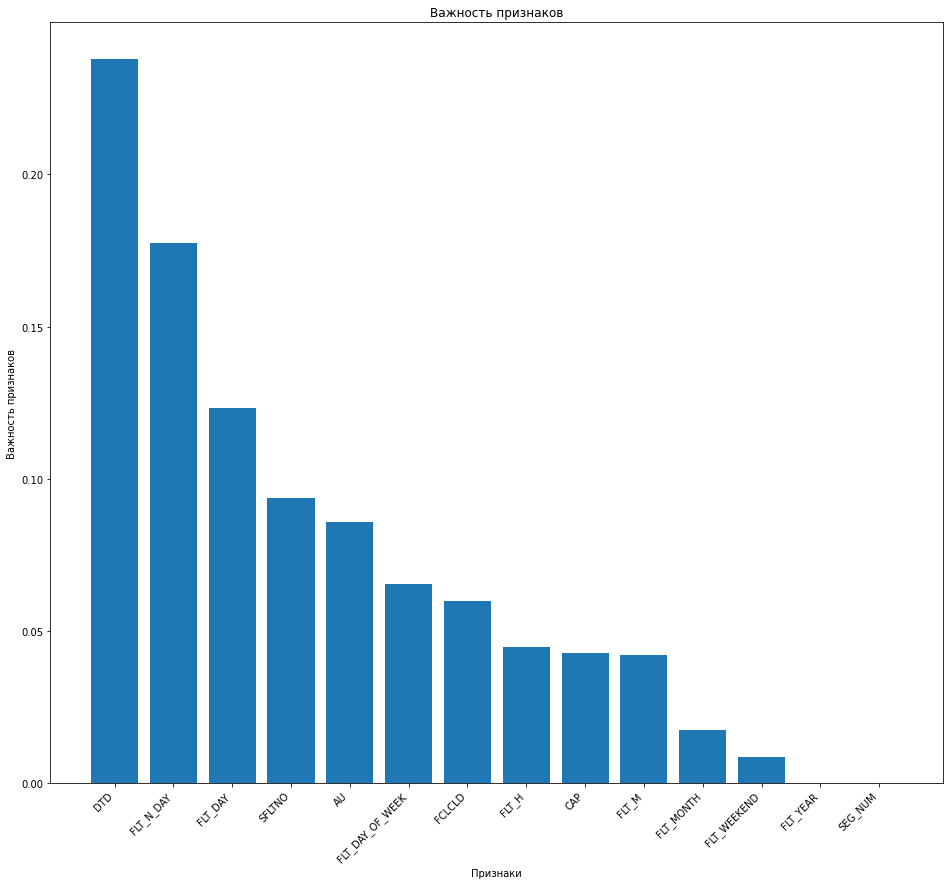

In [63]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title("Важность признаков")
    plt.show()

# Вызов функции для вывода графика важности признаков
plot_feature_importance(model, X.columns)



In [5]:
import os
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

import math

# MLPRegressor

In [4]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем нейронную сеть
        model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

/Users/manforten/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manforten/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/manforten/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/manforten/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/manforten/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_

KeyboardInterrupt: 

In [5]:
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.604652,0.044875
1,H,0.812061,2.699268
2,J,0.739178,0.373785
3,K,0.342281,3.895043
4,O,0.034806,0.929409


In [1]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)
for class_name, prediction in all_predictions.items():
    print(f"Класс: {class_name}, количество мест: {float(prediction)}")

кол-во дней: 10


NameError: name 'np' is not defined

# XGBRegressor

In [9]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем нейронную сеть
        model = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=5, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.236080,0.086711
1,H,0.517593,6.928545
2,J,0.684357,0.452350
3,K,0.510372,2.899600
4,O,0.553815,0.429642
5,X,0.662183,2.117013
6,Y,0.575061,0.346350
7,N,0.666854,82.565781
8,L,0.641628,24.481128
9,Z,0.164370,0.063626


CPU times: user 15min 29s, sys: 1min 22s, total: 16min 51s
Wall time: 2min 28s


In [26]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)

predictions_list = []

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
for class_name, prediction in all_predictions.items():
    predictions_list.append({'Класс': class_name, 'Предсказанное кол-во мест': math.ceil(float(prediction))})

# Создание DataFrame из списка предсказаний
predictions_df = pd.DataFrame(predictions_list)
predictions_df

кол-во дней: 10


,Класс,Предсказанное кол-во мест
0,I,0
1,H,0
2,J,21
3,K,3
4,O,1
5,X,1
6,Y,12
7,N,8
8,L,7
9,Z,1


In [44]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 10,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,6
6,Y,0
7,N,17
8,L,0
9,Z,2


In [33]:
merged_data = filtered_data_subset.merge(predictions_df, left_on='BCL', right_on='Класс', how='left')
merged_data.rename(columns={'PASS': 'Настоящее кол-во мест'}, inplace=True)
merged_data.drop(columns=['BCL'], inplace=True)
merged_data = merged_data[['Класс', 'Предсказанное кол-во мест', 'Настоящее кол-во мест']]
merged_data

,Класс,Предсказанное кол-во мест,Настоящее кол-во мест
0,I,0,0
1,H,0,0
2,J,21,2
3,K,3,0
4,O,1,0
5,X,1,6
6,Y,12,0
7,N,8,17
8,L,7,0
9,Z,1,2


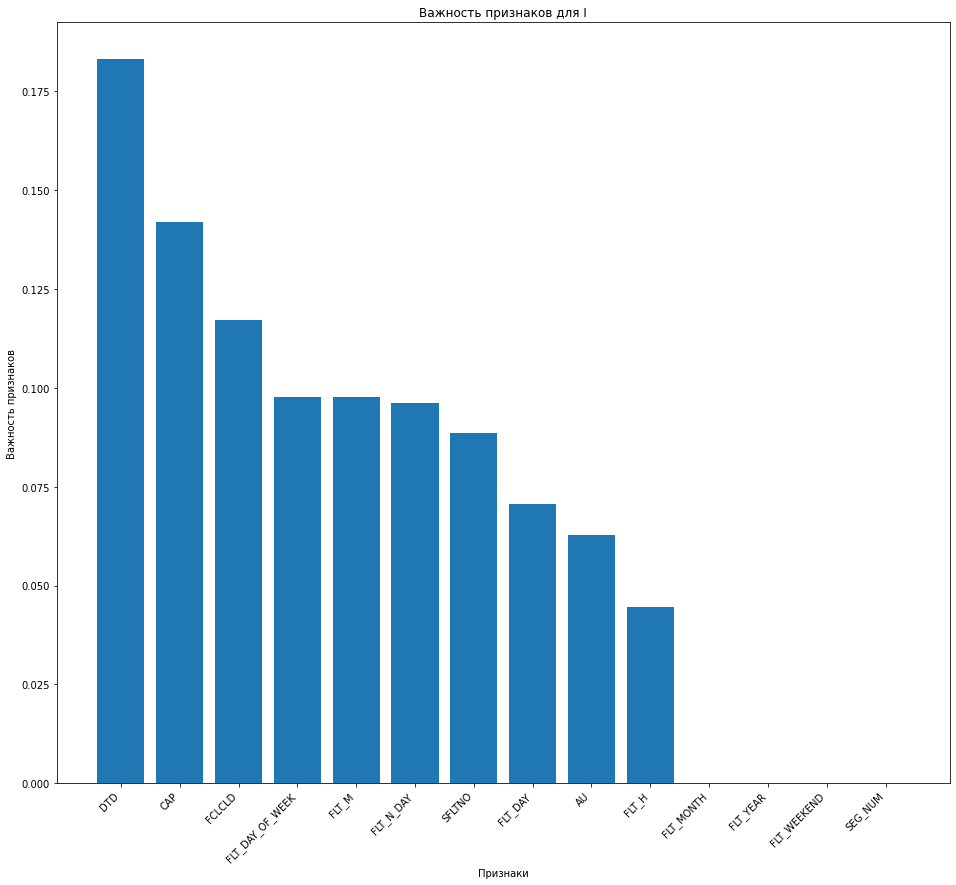

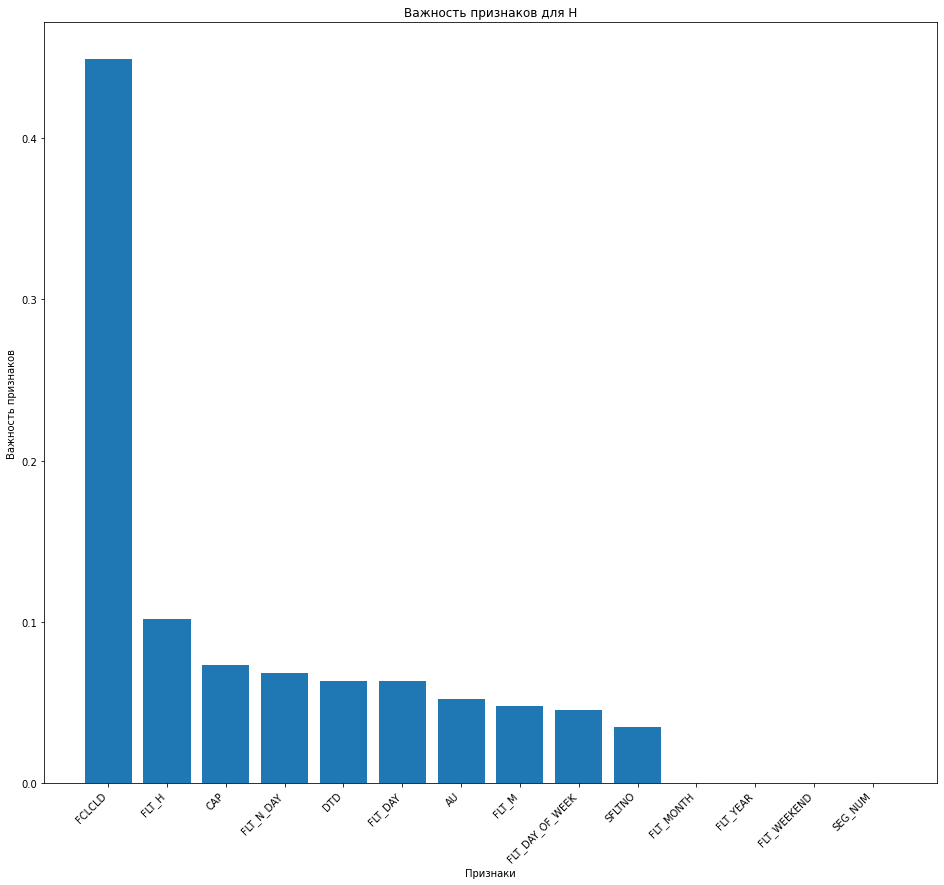

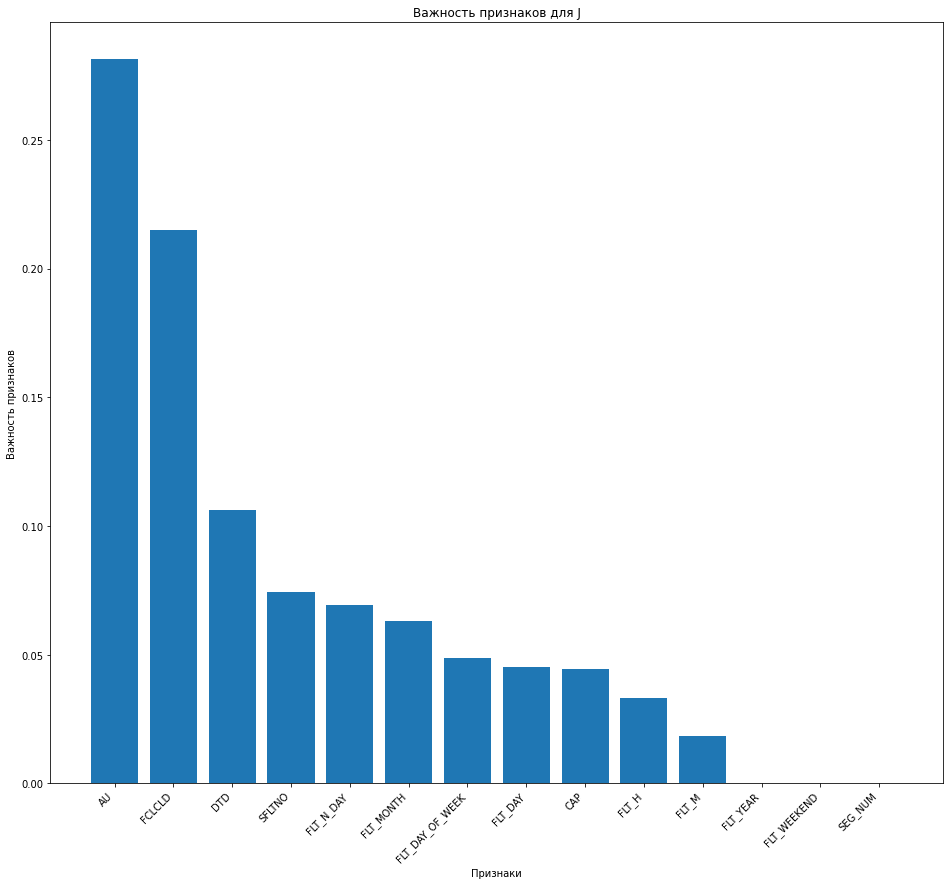

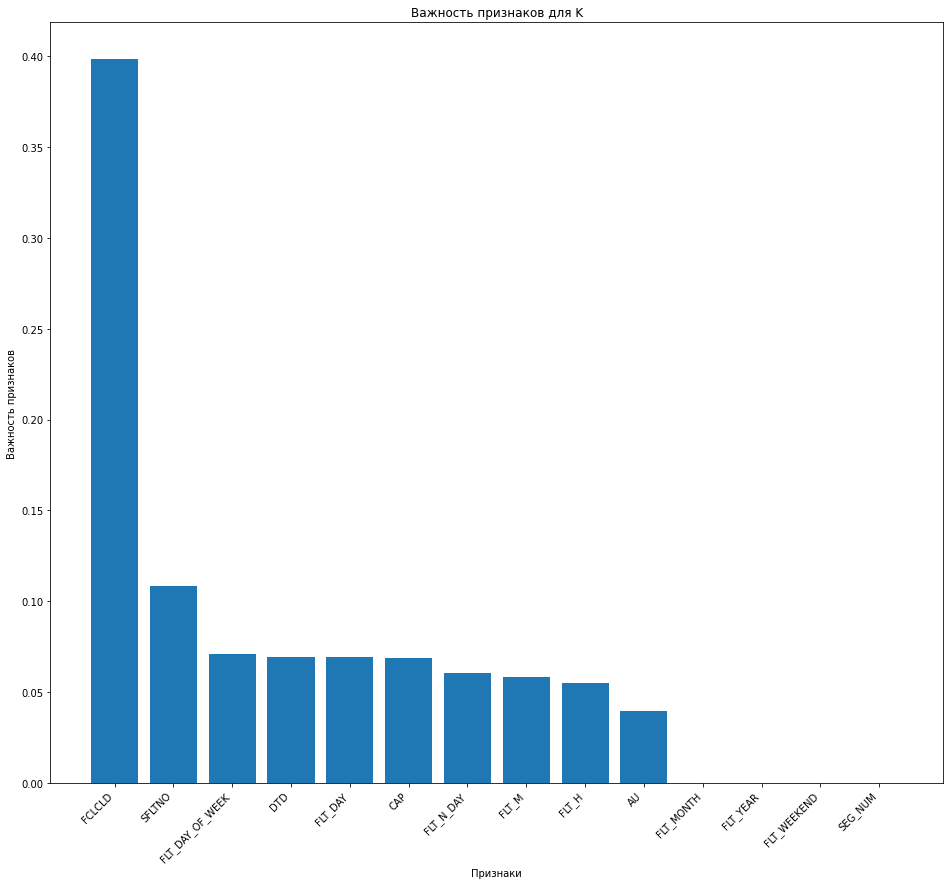

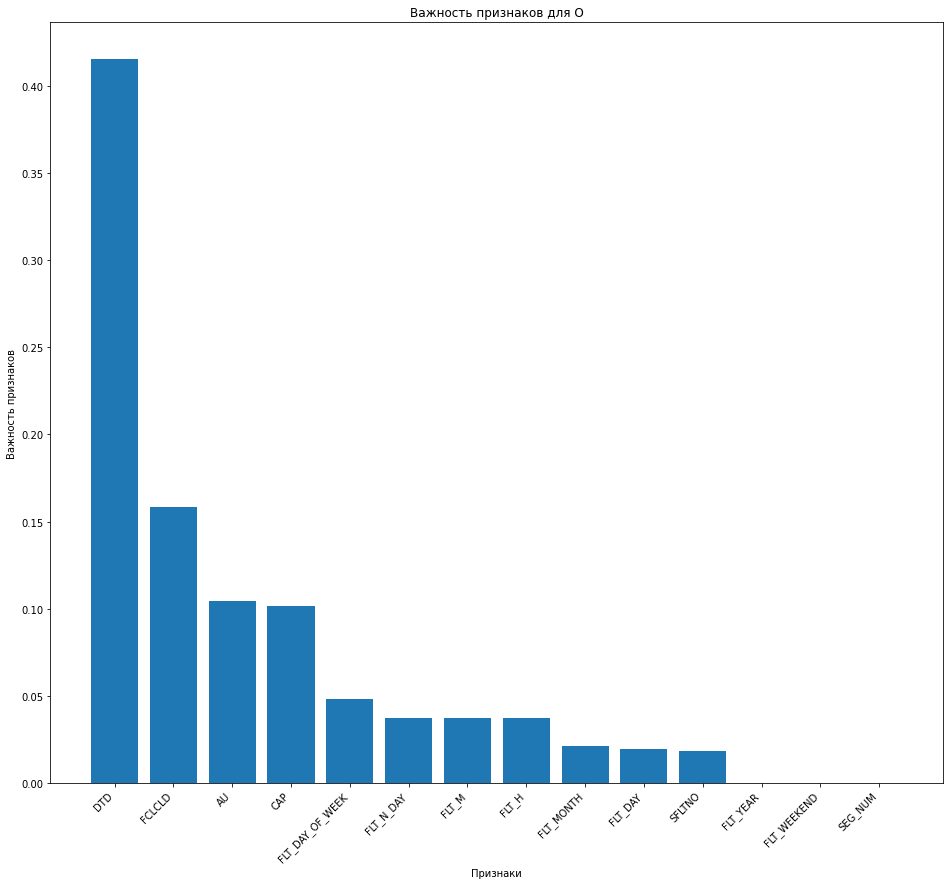

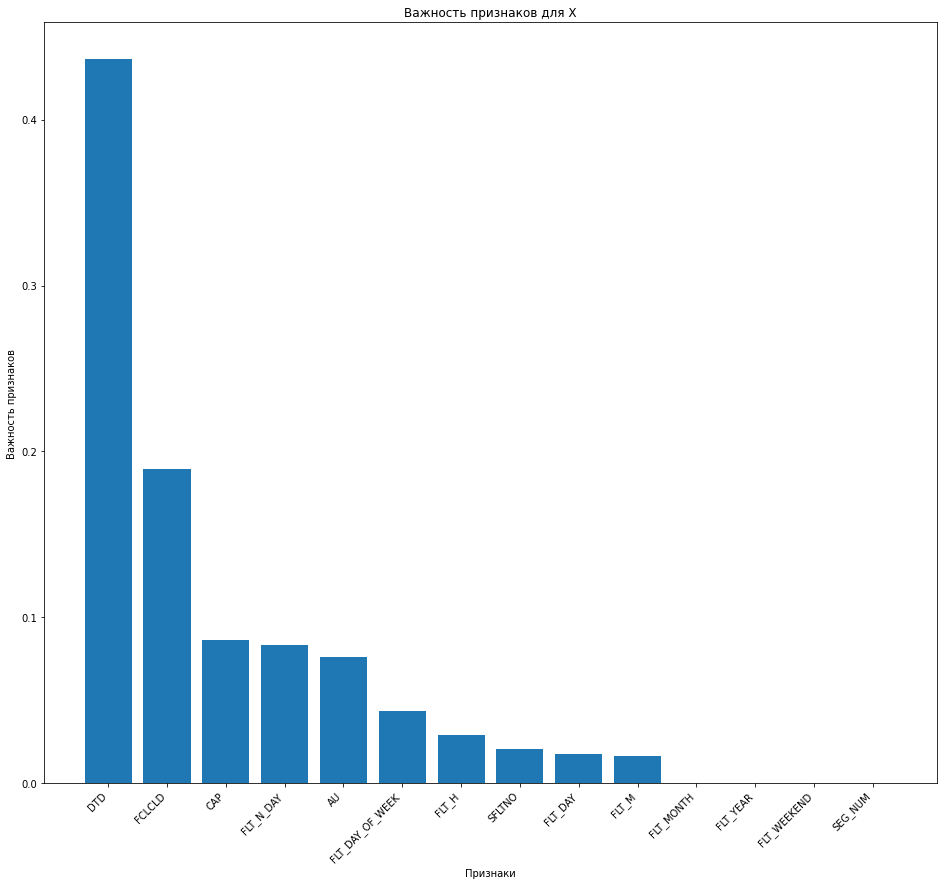

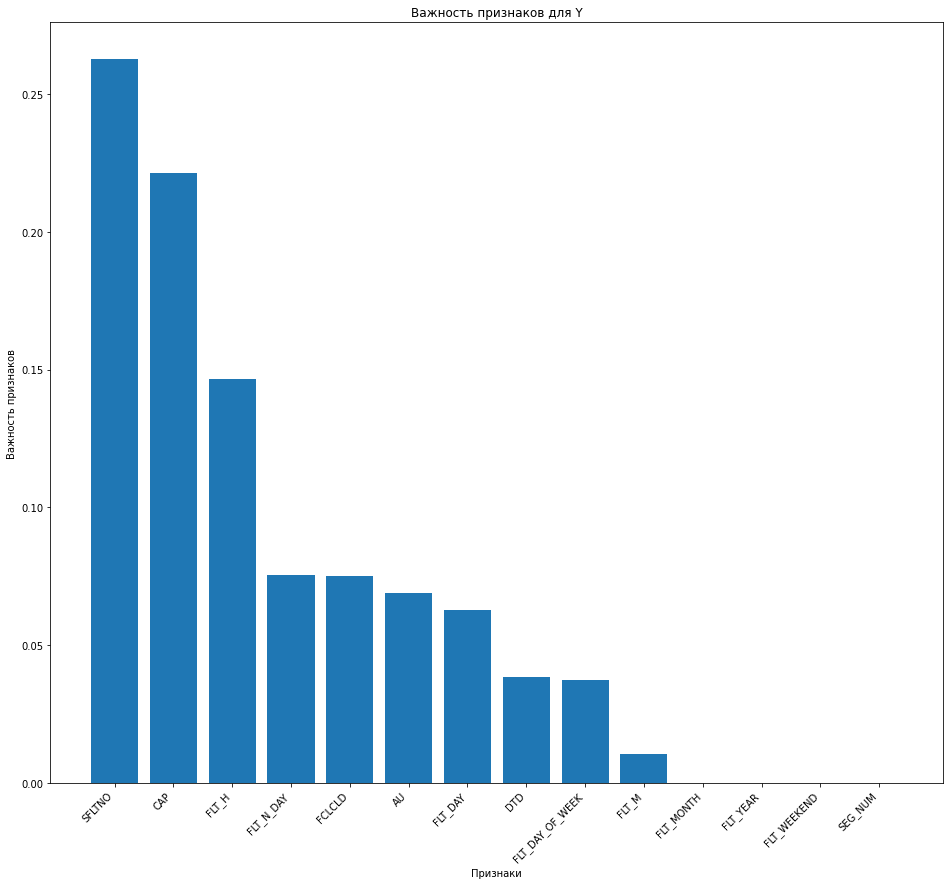

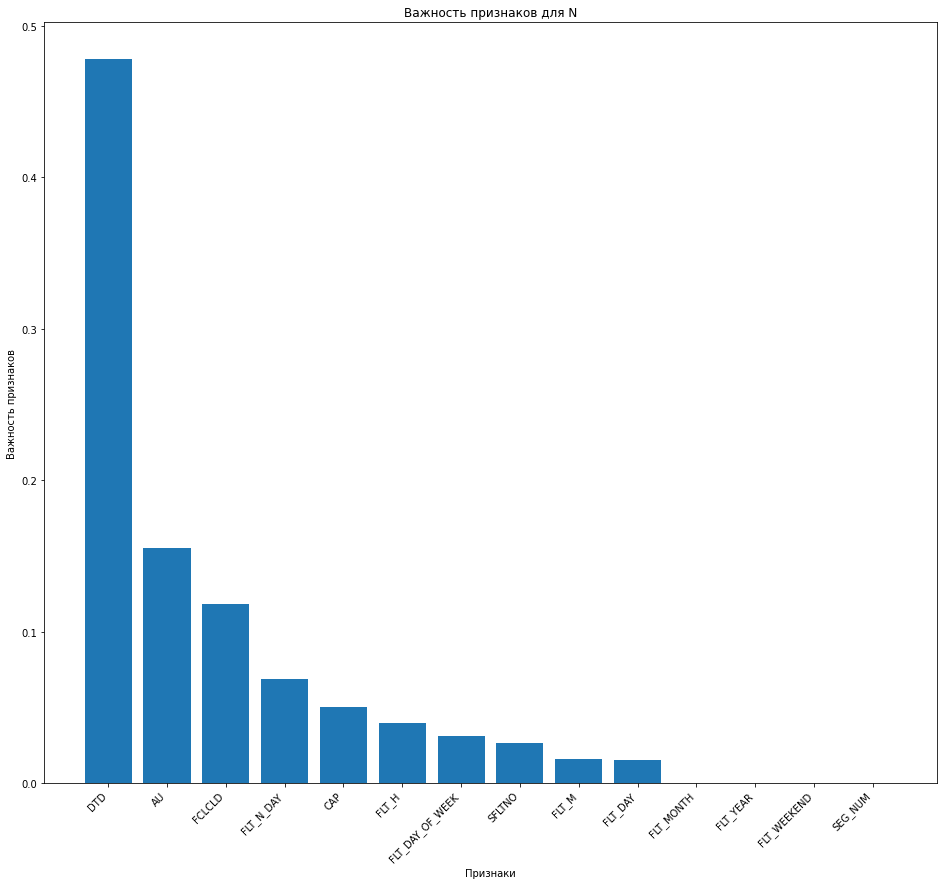

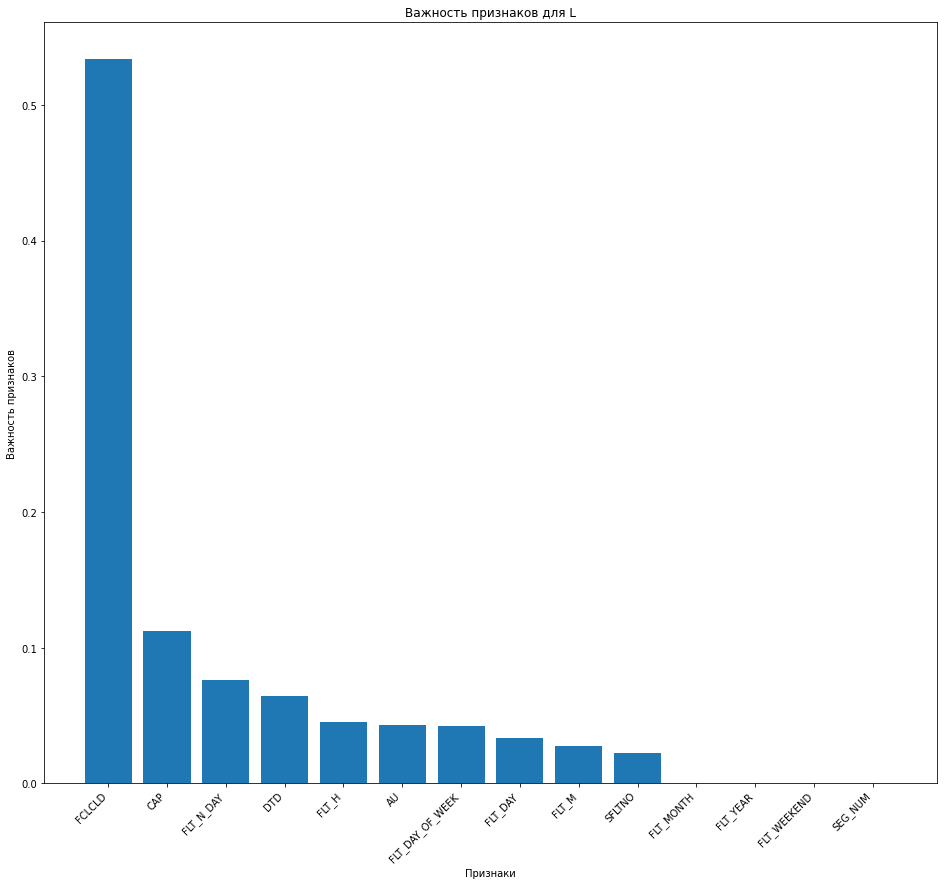

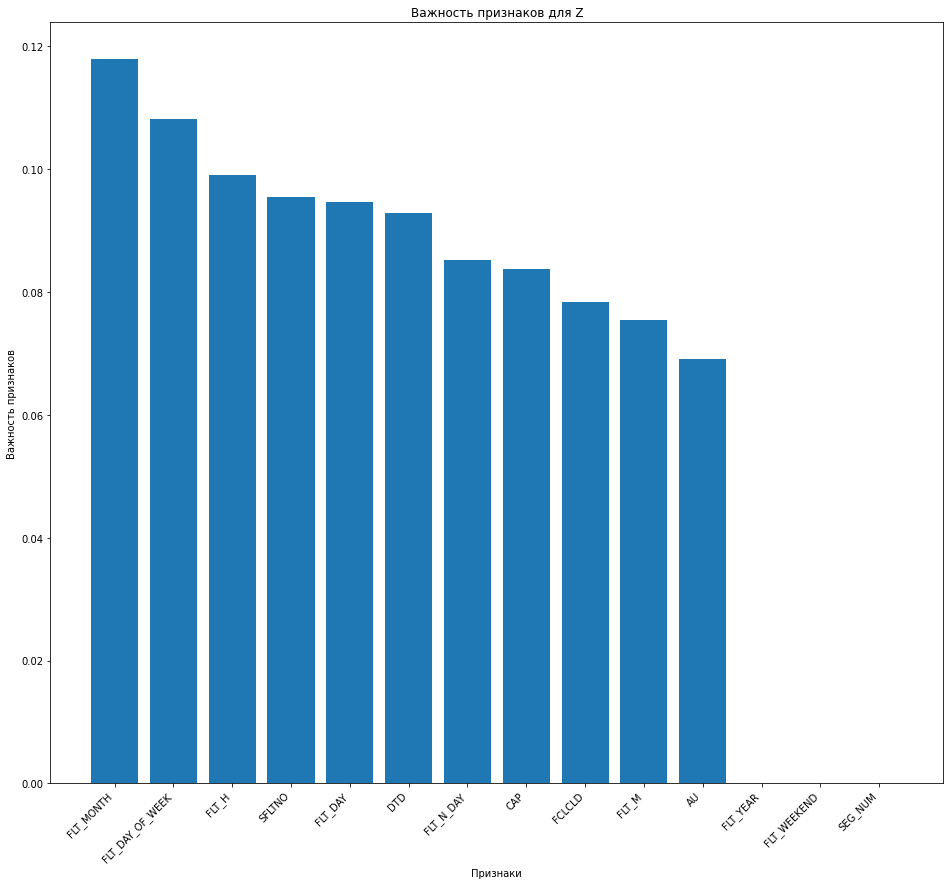

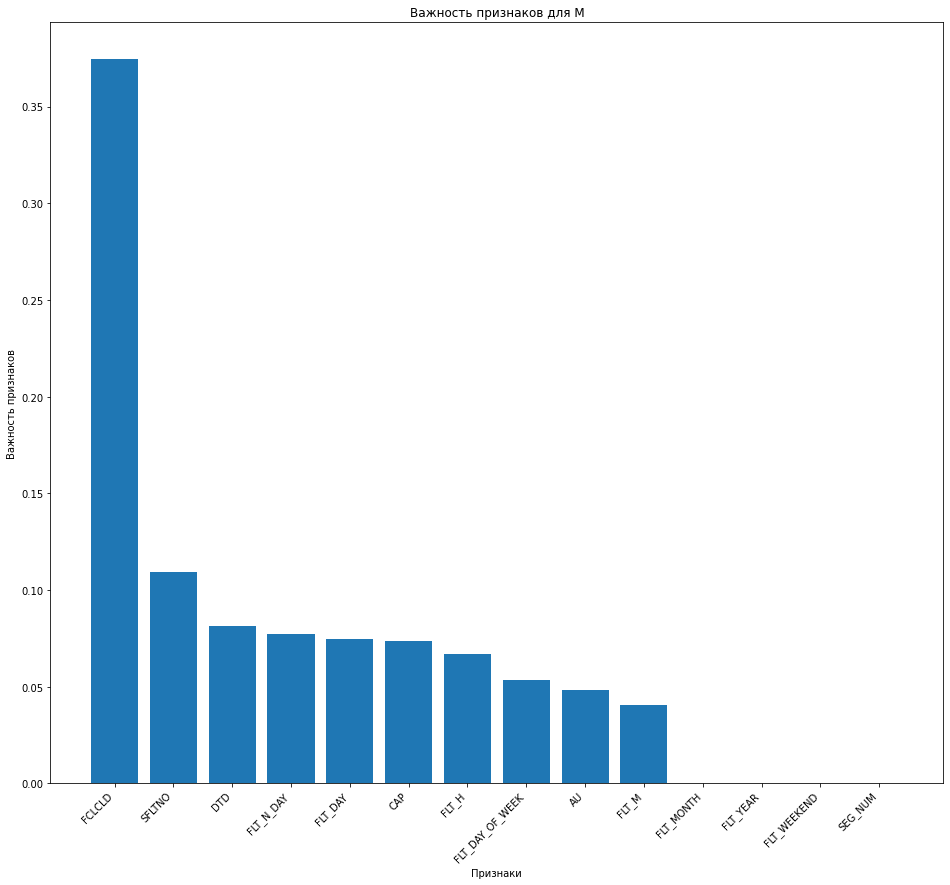

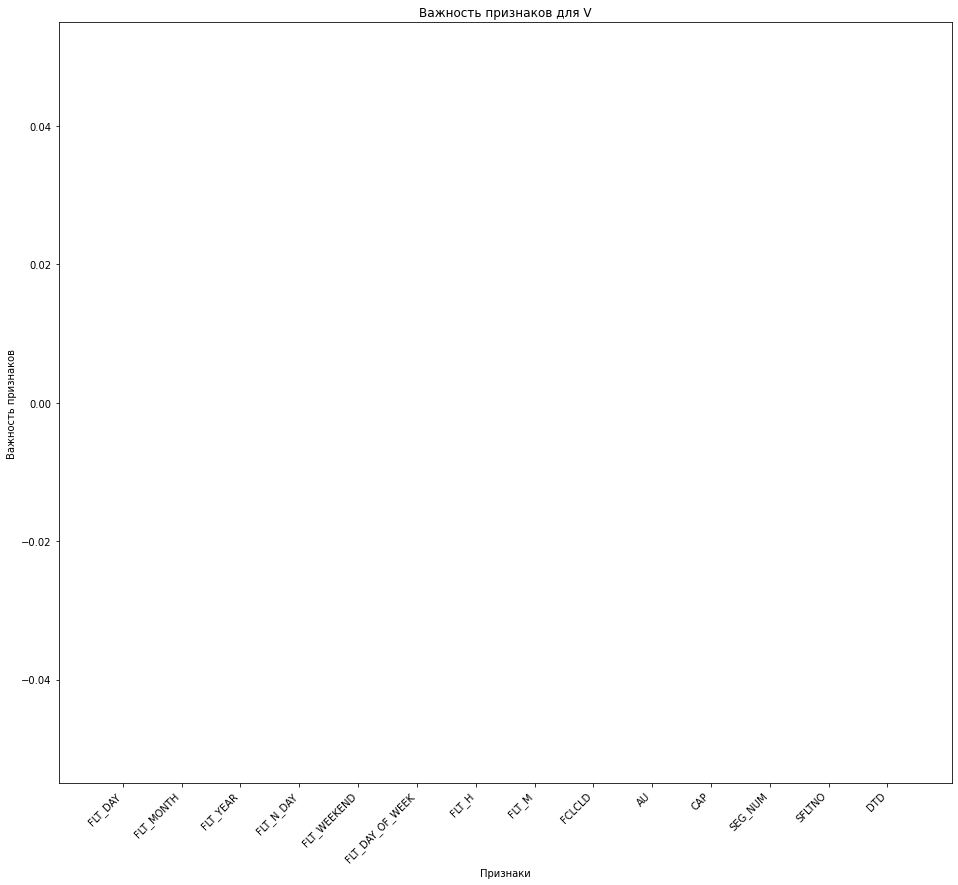

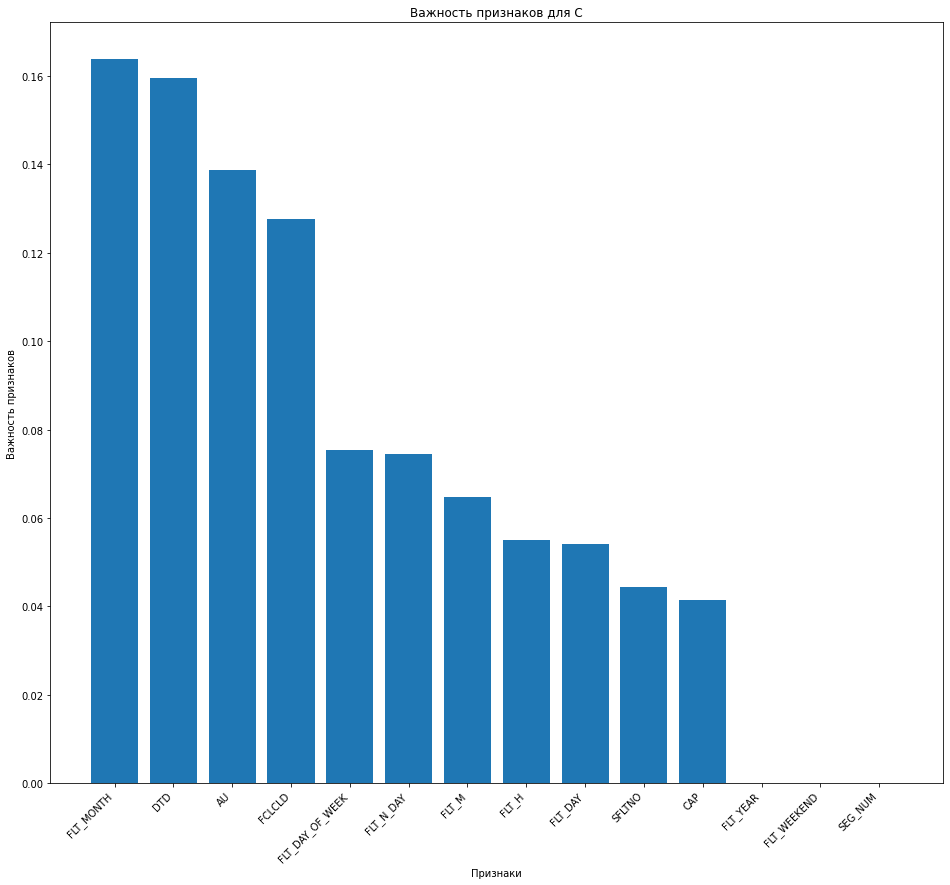

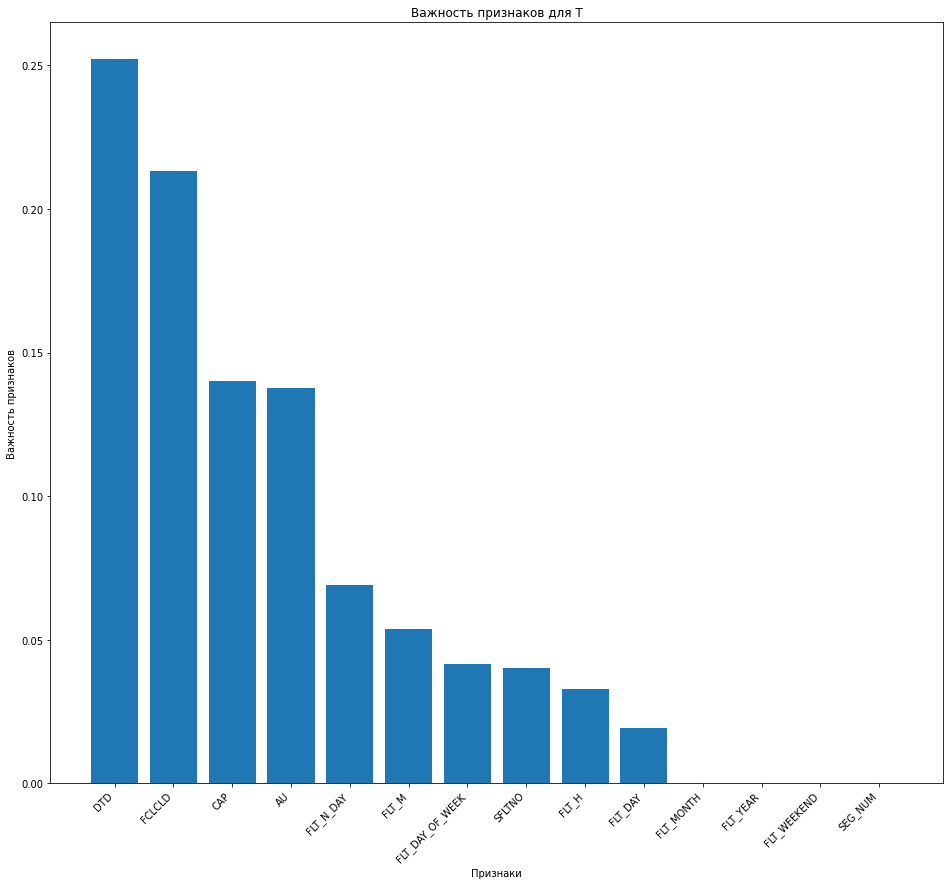

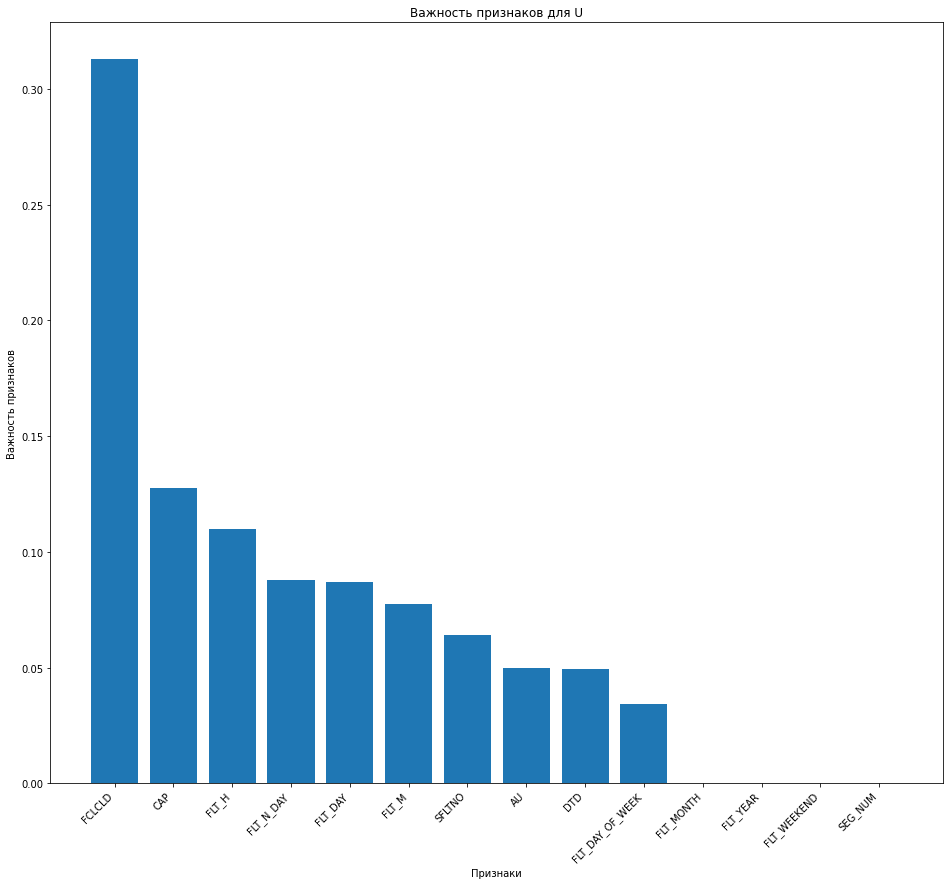

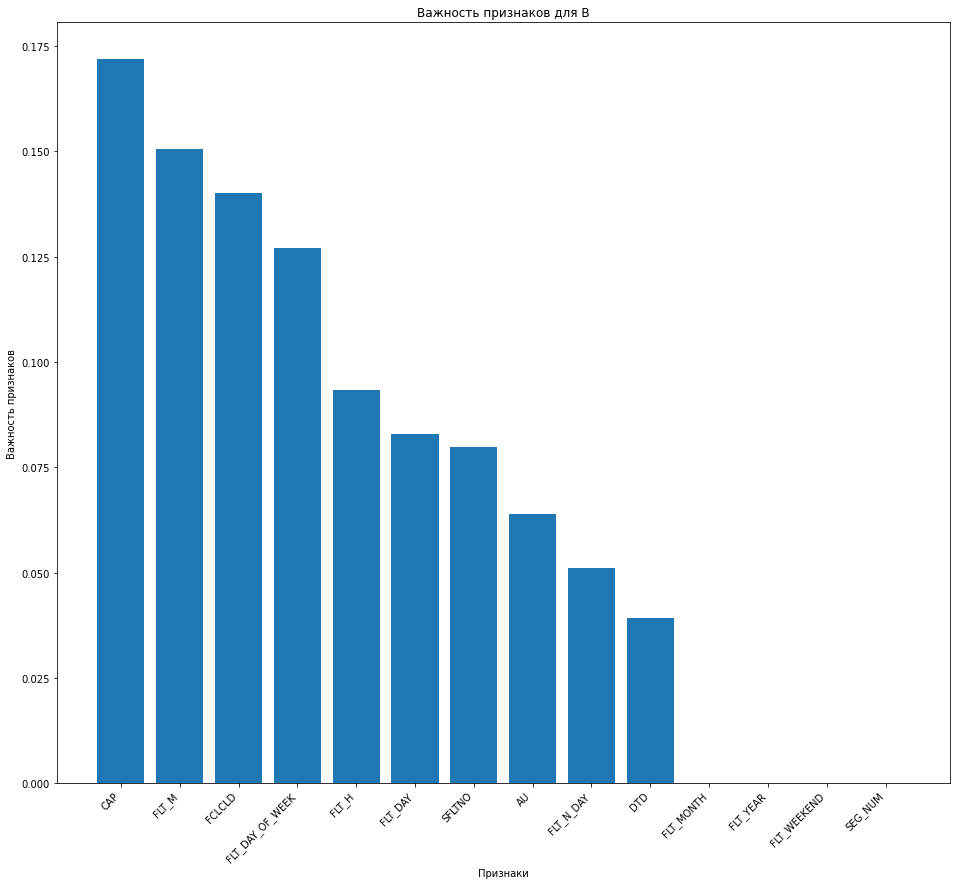

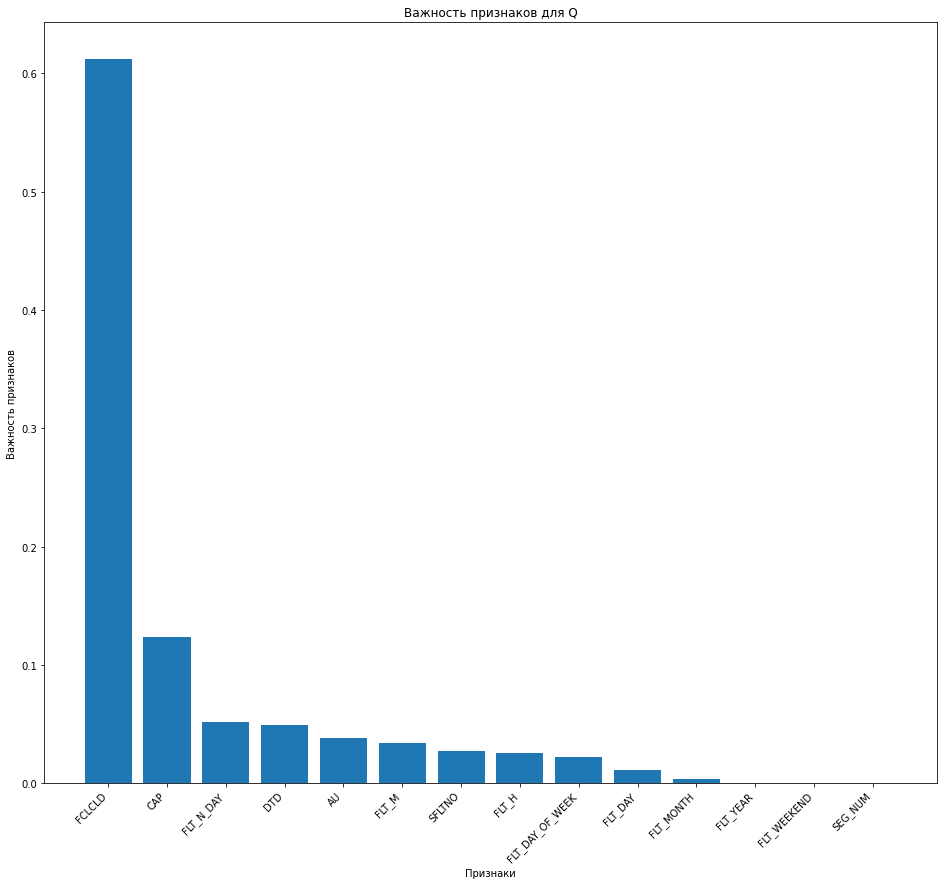

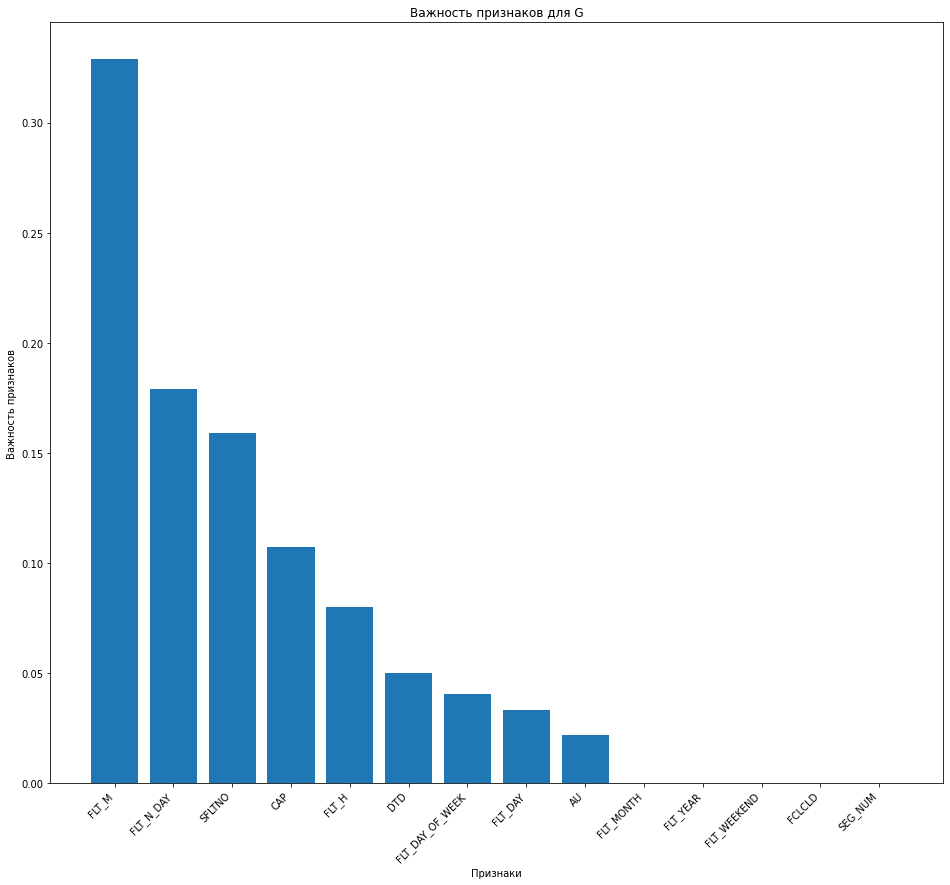

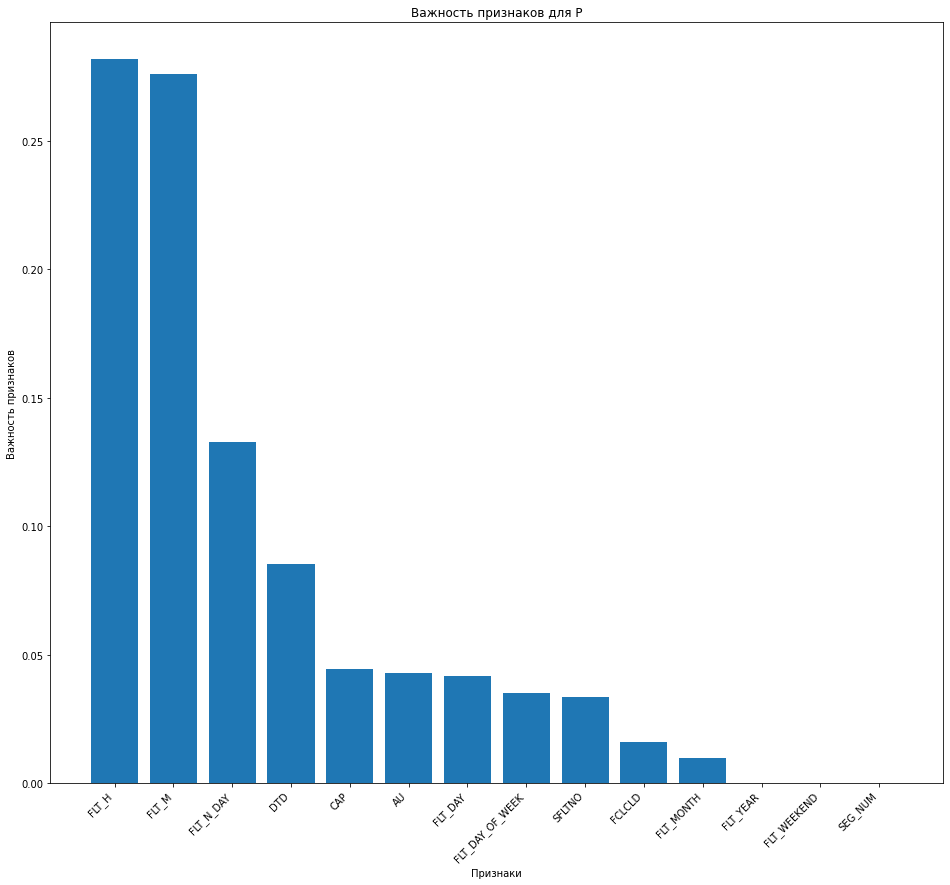

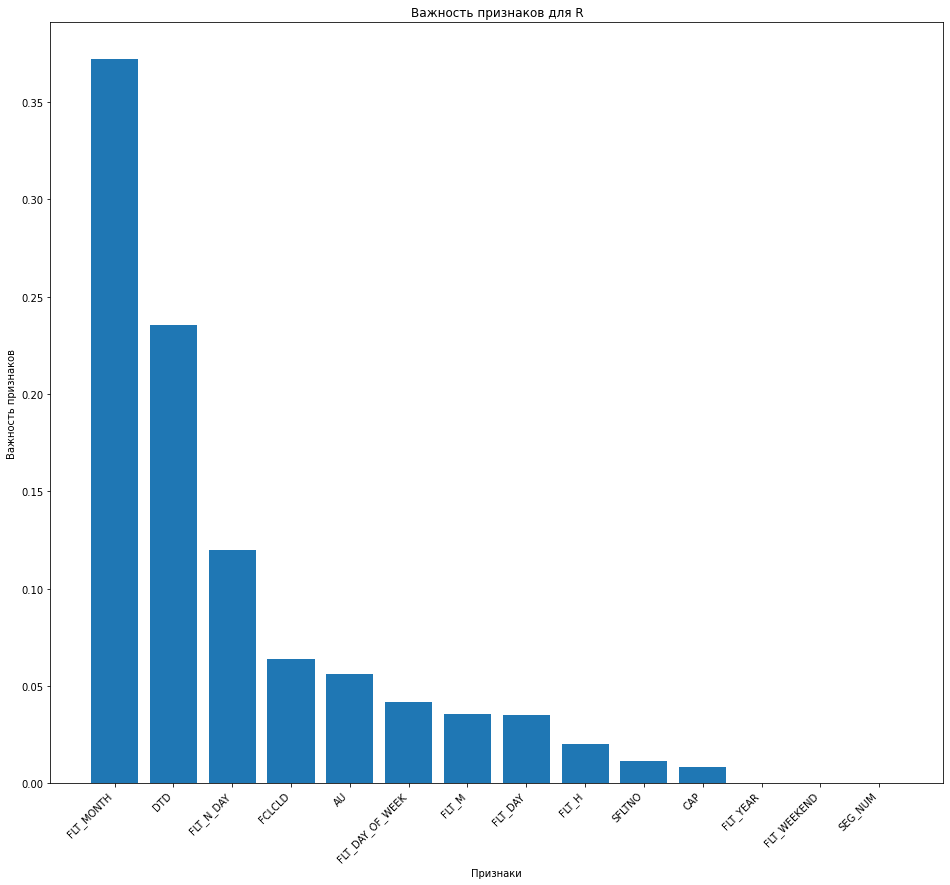

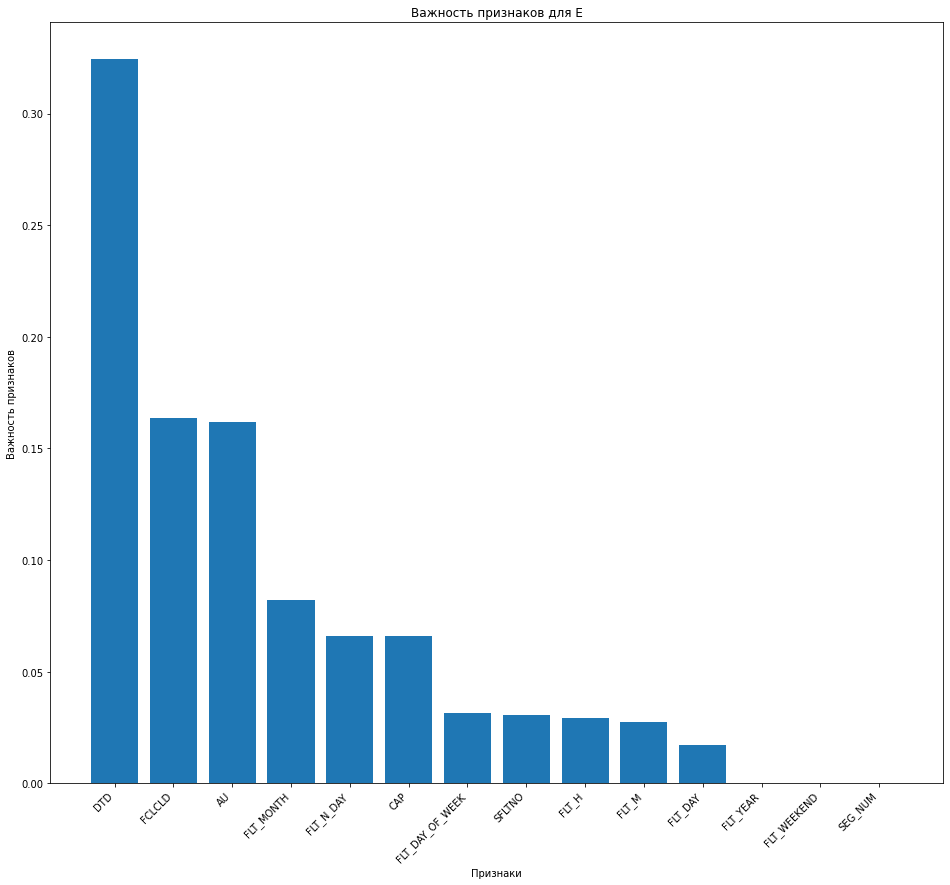

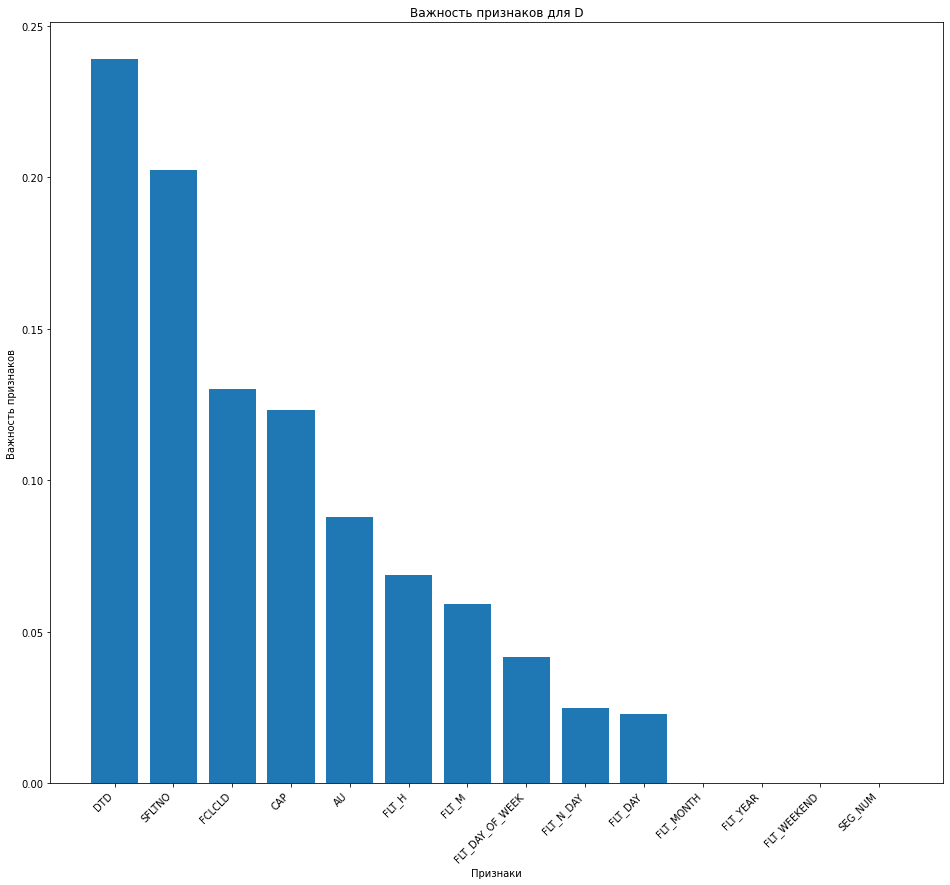

In [39]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, class_name):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title(f"Важность признаков для {class_name}")
    plt.show()

for class_name, model in models.items():# Вызов функции для вывода графика важности признаков
    plot_feature_importance(model, X.columns, class_name)

# ElasticNet

In [52]:
from sklearn.linear_model import ElasticNet

In [56]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем нейронную сеть
        model = ElasticNet(alpha=0.0001, l1_ratio=0.5, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
        # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.060648,0.106624
1,H,0.183296,11.729879
2,J,0.142873,1.228352
3,K,0.155709,4.999930
4,O,0.305810,0.668452
5,X,0.348894,4.080321
6,Y,0.069636,0.758301
7,N,0.398164,149.156871
8,L,0.300888,47.757828
9,Z,0.025595,0.074193


CPU times: user 7min 48s, sys: 3min, total: 10min 48s
Wall time: 1min 43s


In [57]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)

predictions_list = []

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
for class_name, prediction in all_predictions.items():
    predictions_list.append({'Класс': class_name, 'Предсказанное кол-во мест': math.ceil(float(prediction))})

# Создание DataFrame из списка предсказаний
predictions_df = pd.DataFrame(predictions_list)
predictions_df

кол-во дней: 10


,Класс,Предсказанное кол-во мест
0,I,12
1,H,-163
2,J,-258
3,K,-109
4,O,50
5,X,-176
6,Y,132
7,N,268
8,L,-505
9,Z,9


In [44]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 10,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,6
6,Y,0
7,N,17
8,L,0
9,Z,2


In [33]:
merged_data = filtered_data_subset.merge(predictions_df, left_on='BCL', right_on='Класс', how='left')
merged_data.rename(columns={'PASS': 'Настоящее кол-во мест'}, inplace=True)
merged_data.drop(columns=['BCL'], inplace=True)
merged_data = merged_data[['Класс', 'Предсказанное кол-во мест', 'Настоящее кол-во мест']]
merged_data

,Класс,Предсказанное кол-во мест,Настоящее кол-во мест
0,I,0,0
1,H,0,0
2,J,21,2
3,K,3,0
4,O,1,0
5,X,1,6
6,Y,12,0
7,N,8,17
8,L,7,0
9,Z,1,2


In [58]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, class_name):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title(f"Важность признаков для {class_name}")
    plt.show()

for class_name, model in models.items():# Вызов функции для вывода графика важности признаков
    plot_feature_importance(model, X.columns, class_name)

Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.


# Ridge

In [60]:
from sklearn.linear_model import Ridge

In [63]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем нейронную сеть
        model = Ridge(alpha=0.0001, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.060947,0.106590
1,H,0.183313,11.729637
2,J,0.146706,1.222859
3,K,0.155735,4.999775
4,O,0.306610,0.667682
5,X,0.349462,4.076761
6,Y,0.069628,0.758307
7,N,0.399680,148.781126
8,L,0.300997,47.750352
9,Z,0.025652,0.074189


CPU times: user 28.6 s, sys: 21.7 s, total: 50.4 s
Wall time: 14.7 s


In [64]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)

predictions_list = []

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
for class_name, prediction in all_predictions.items():
    predictions_list.append({'Класс': class_name, 'Предсказанное кол-во мест': math.ceil(float(prediction))})

# Создание DataFrame из списка предсказаний
predictions_df = pd.DataFrame(predictions_list)
predictions_df

кол-во дней: 10


,Класс,Предсказанное кол-во мест
0,I,-16
1,H,-77
2,J,24
3,K,-148
4,O,-67
5,X,-419
6,Y,136
7,N,-2276
8,L,-817
9,Z,2


In [44]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 10,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,6
6,Y,0
7,N,17
8,L,0
9,Z,2


In [33]:
merged_data = filtered_data_subset.merge(predictions_df, left_on='BCL', right_on='Класс', how='left')
merged_data.rename(columns={'PASS': 'Настоящее кол-во мест'}, inplace=True)
merged_data.drop(columns=['BCL'], inplace=True)
merged_data = merged_data[['Класс', 'Предсказанное кол-во мест', 'Настоящее кол-во мест']]
merged_data

,Класс,Предсказанное кол-во мест,Настоящее кол-во мест
0,I,0,0
1,H,0,0
2,J,21,2
3,K,3,0
4,O,1,0
5,X,1,6
6,Y,12,0
7,N,8,17
8,L,7,0
9,Z,1,2


In [65]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, class_name):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title(f"Важность признаков для {class_name}")
    plt.show()

for class_name, model in models.items():# Вызов функции для вывода графика важности признаков
    plot_feature_importance(model, X.columns, class_name)

Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.


# RandomForestRegressor

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем нейронную сеть
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.944913,0.006253
1,H,0.973216,0.384682
2,J,0.958116,0.060024
3,K,0.975710,0.143849
4,O,0.961490,0.037082
5,X,0.980048,0.125033
6,Y,0.928458,0.058311
7,N,0.982076,4.442186
8,L,0.986543,0.919250
9,Z,0.952483,0.003618


CPU times: user 59min 32s, sys: 12.4 s, total: 59min 44s
Wall time: 59min 50s


In [73]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)

predictions_list = []

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
for class_name, prediction in all_predictions.items():
    predictions_list.append({'Класс': class_name, 'Предсказанное кол-во мест': math.ceil(float(prediction))})

# Создание DataFrame из списка предсказаний
predictions_df = pd.DataFrame(predictions_list)
predictions_df

кол-во дней: 10


,Класс,Предсказанное кол-во мест
0,I,0
1,H,2
2,J,23
3,K,0
4,O,1
5,X,1
6,Y,2
7,N,1
8,L,0
9,Z,0


In [74]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 10,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,6
6,Y,0
7,N,17
8,L,0
9,Z,2


In [75]:
merged_data = filtered_data_subset.merge(predictions_df, left_on='BCL', right_on='Класс', how='left')
merged_data.rename(columns={'PASS': 'Настоящее кол-во мест'}, inplace=True)
merged_data.drop(columns=['BCL'], inplace=True)
merged_data = merged_data[['Класс', 'Предсказанное кол-во мест', 'Настоящее кол-во мест']]
merged_data

,Класс,Предсказанное кол-во мест,Настоящее кол-во мест
0,I,0,0
1,H,2,0
2,J,23,2
3,K,0,0
4,O,1,0
5,X,1,6
6,Y,2,0
7,N,1,17
8,L,0,0
9,Z,0,2


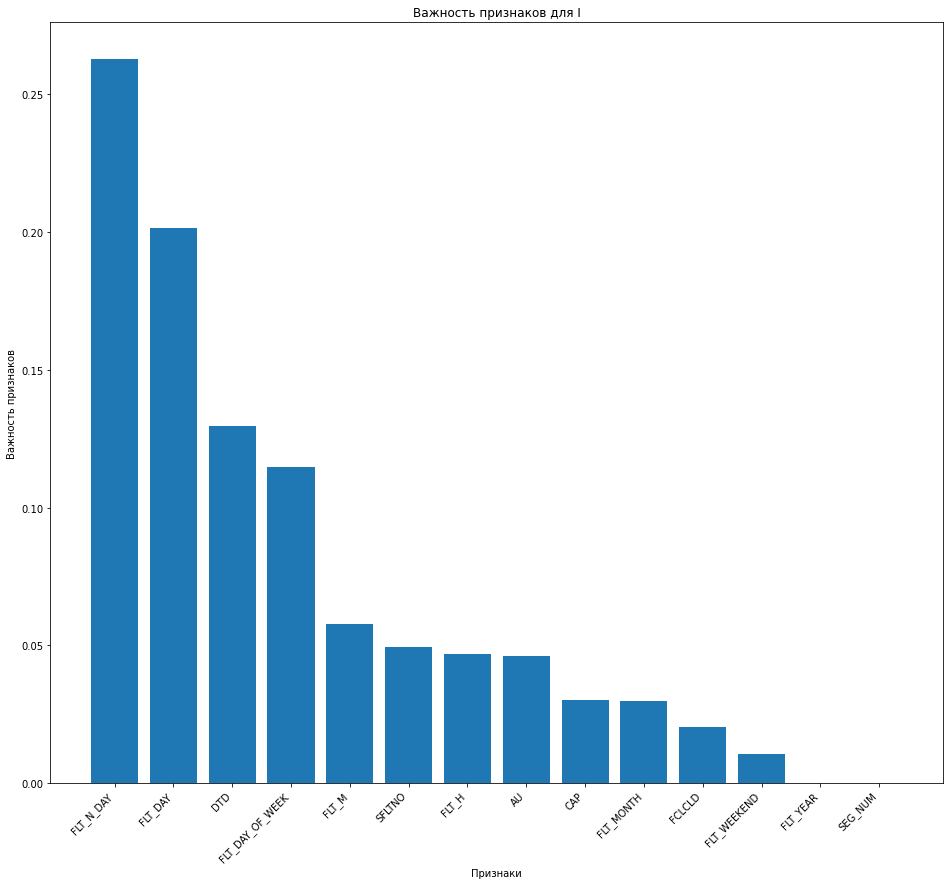

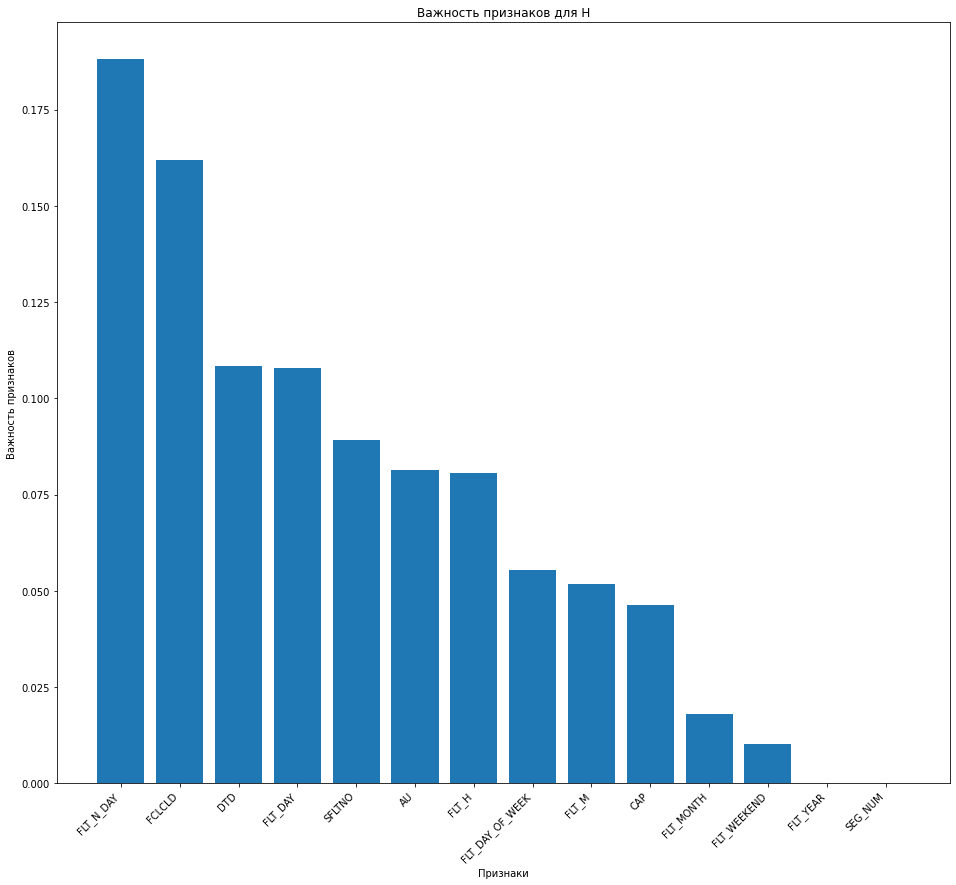

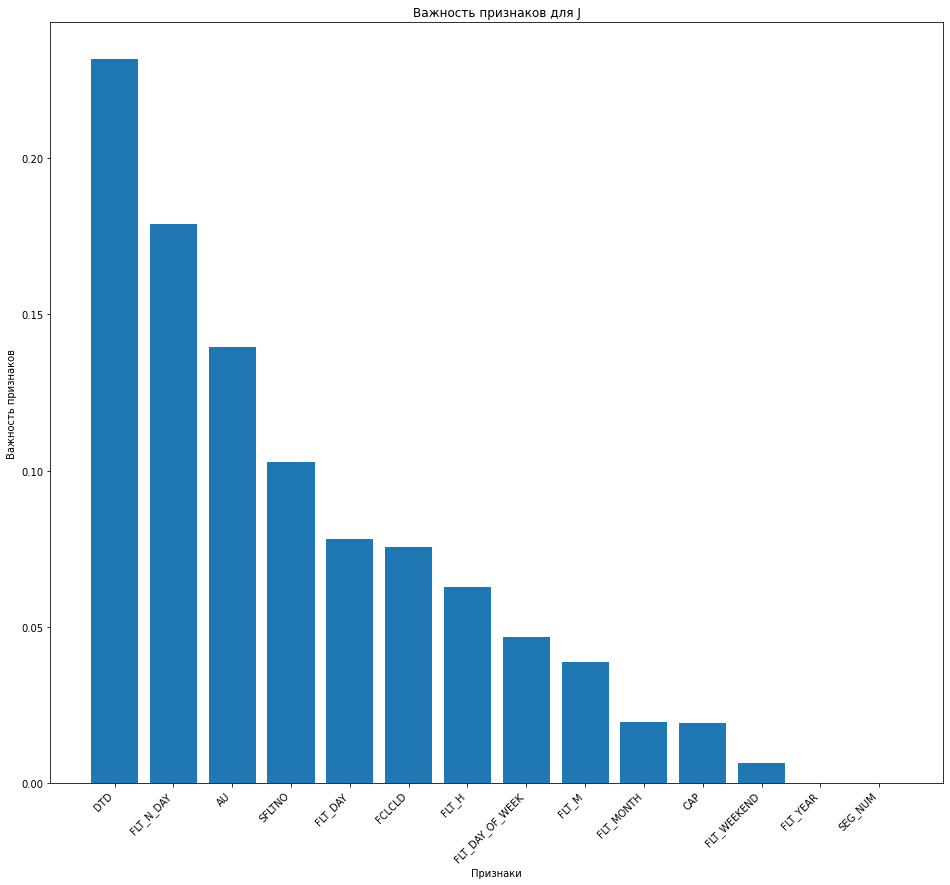

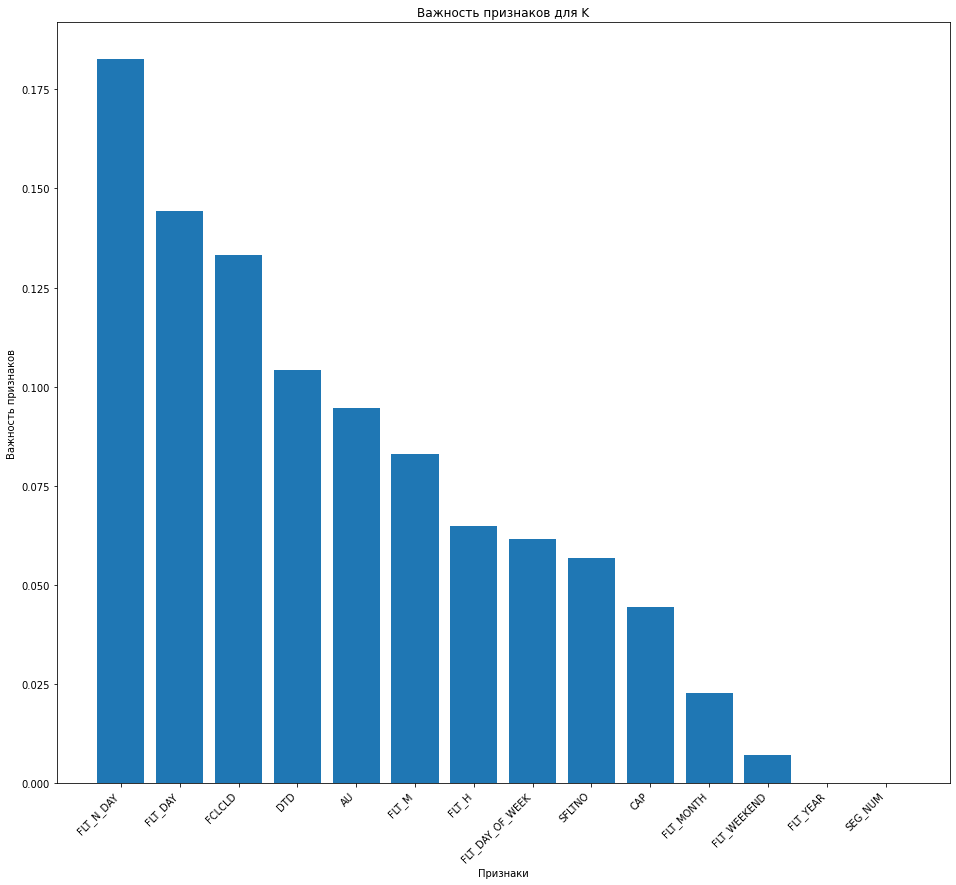

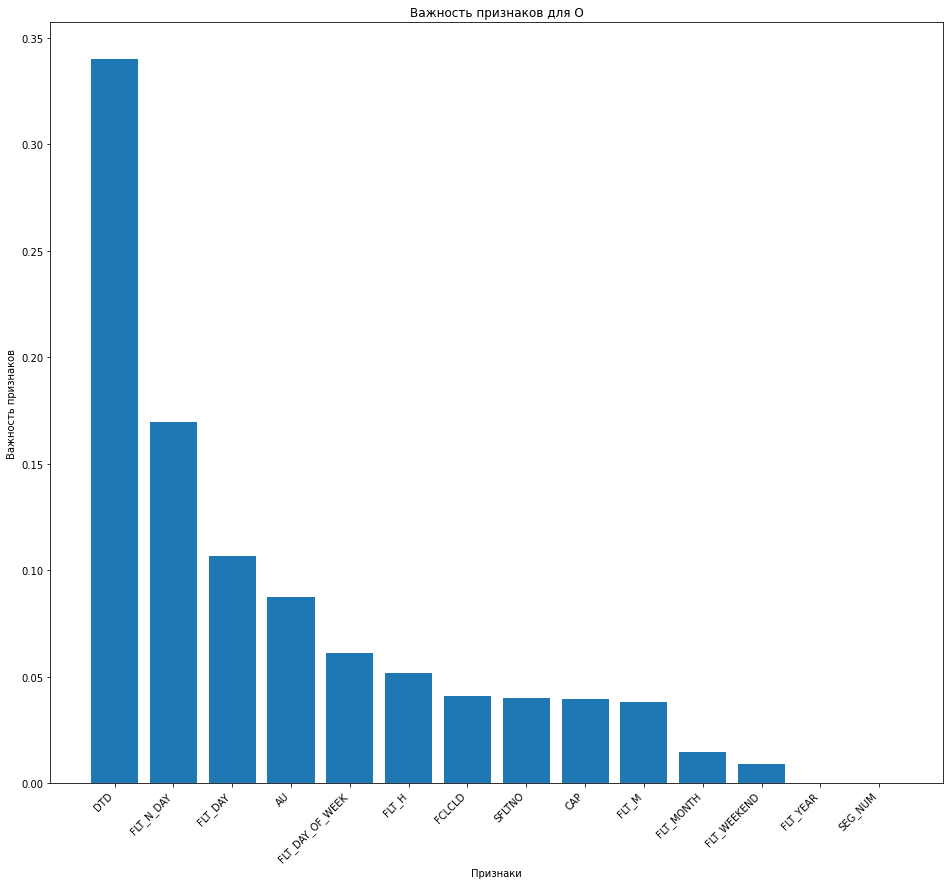

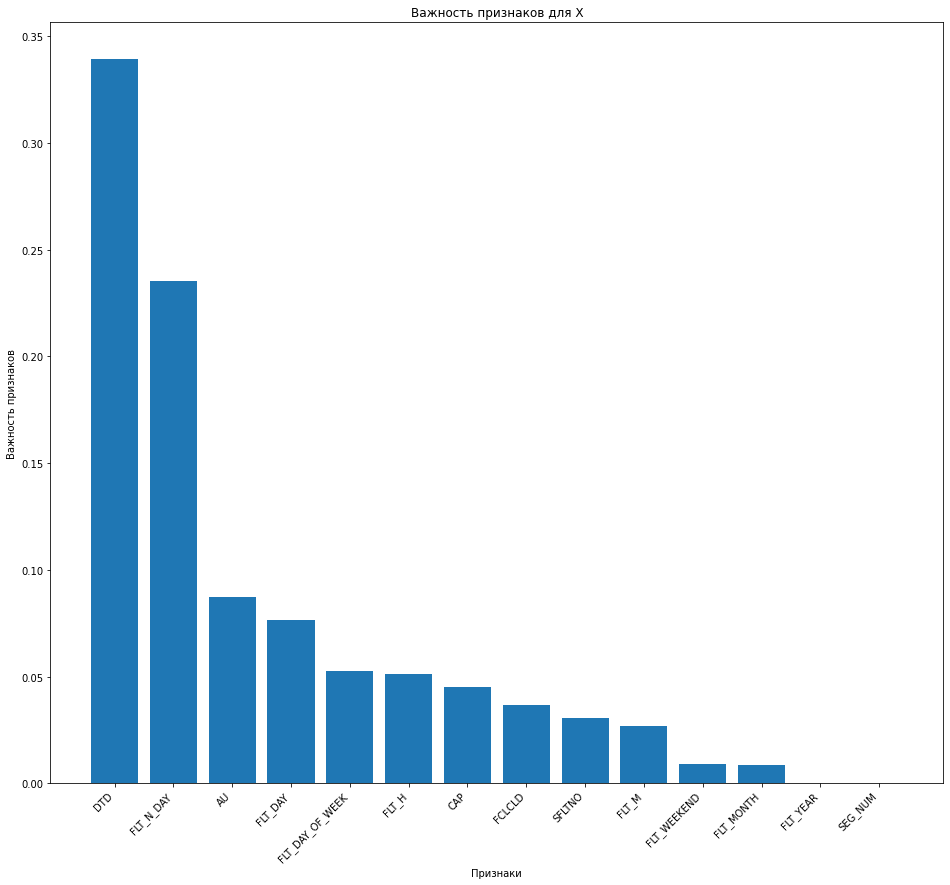

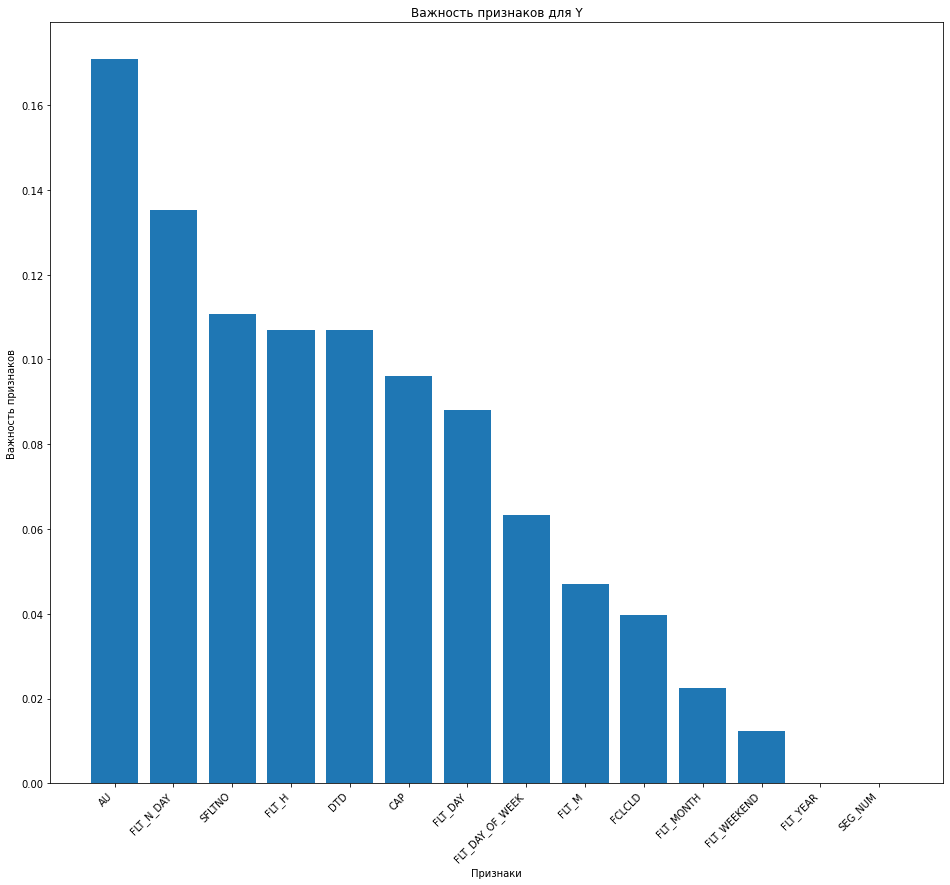

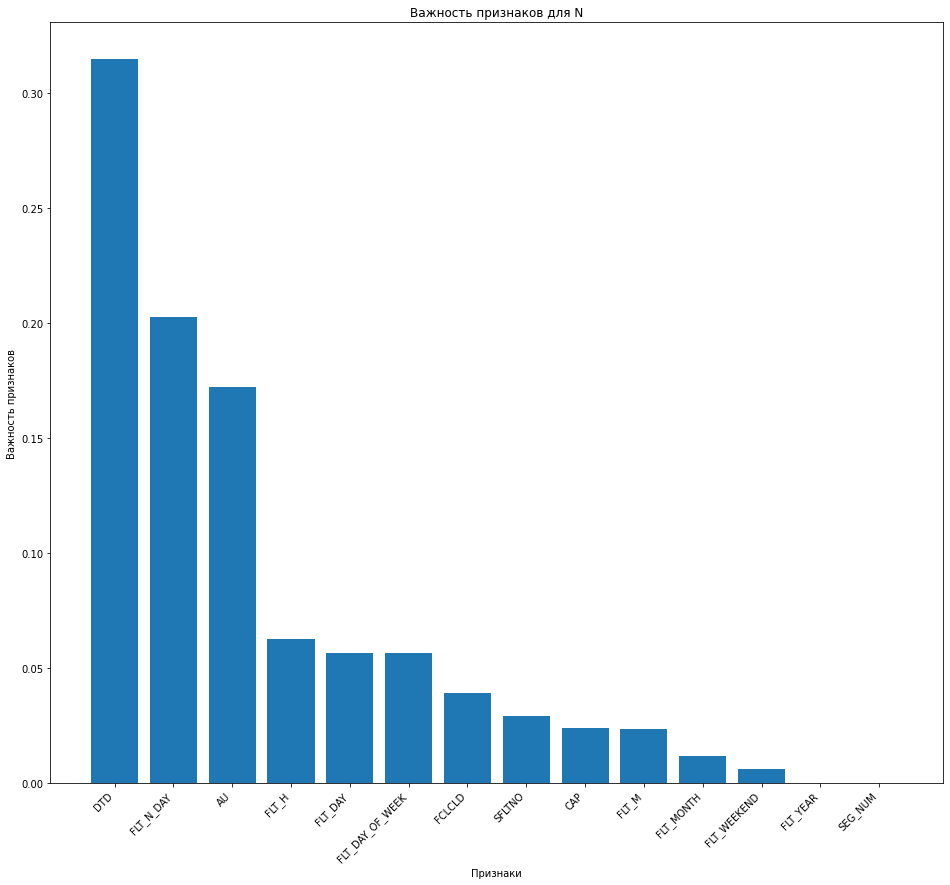

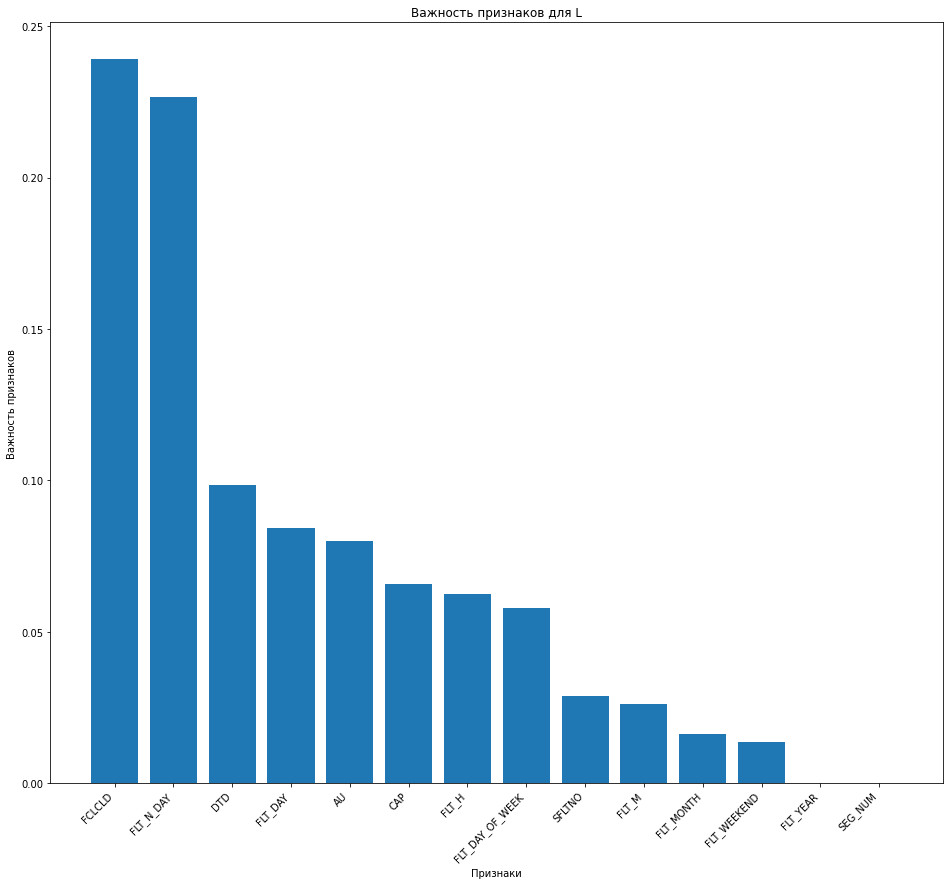

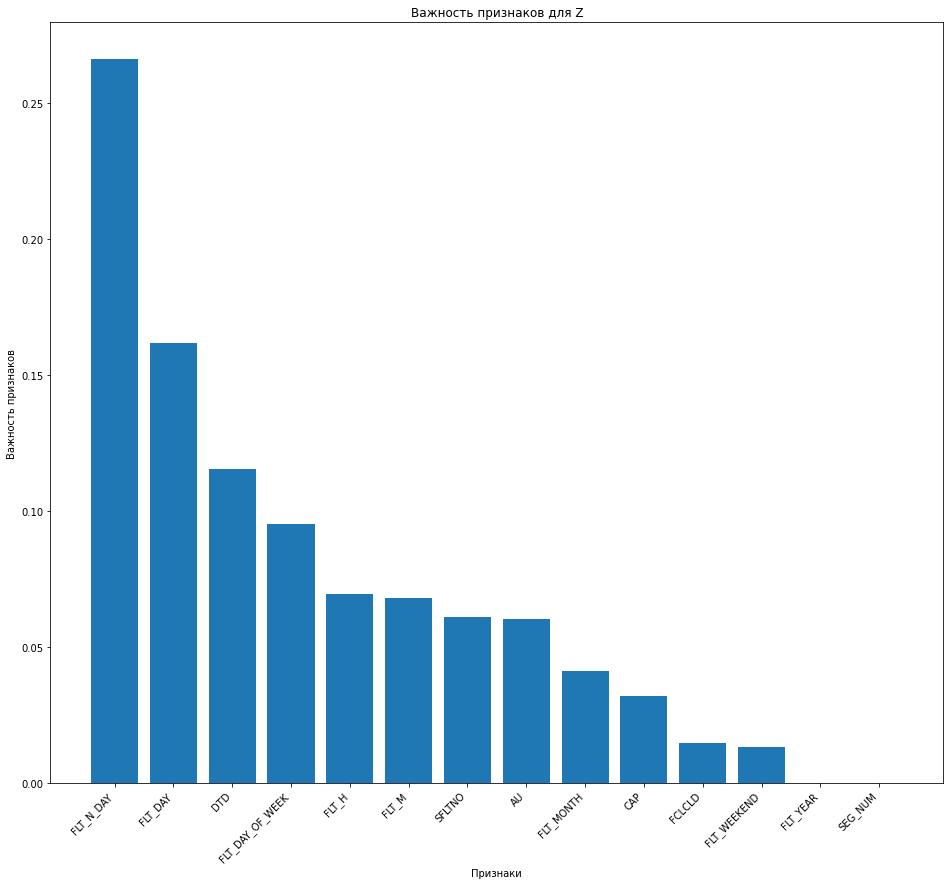

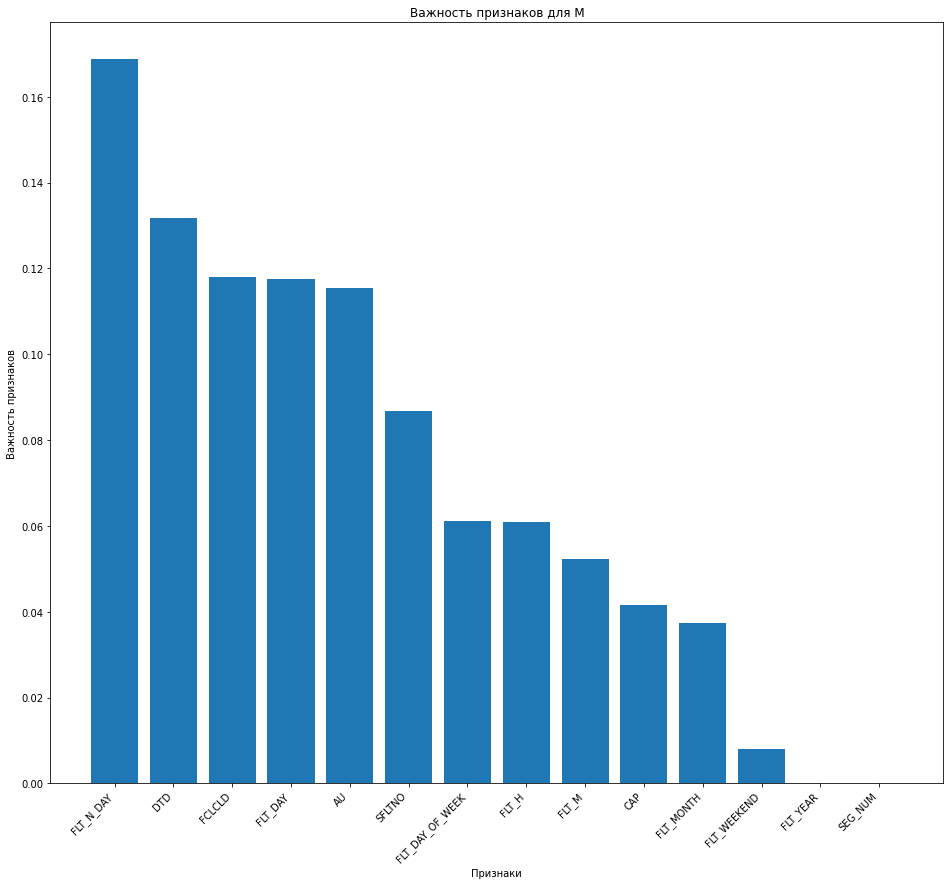

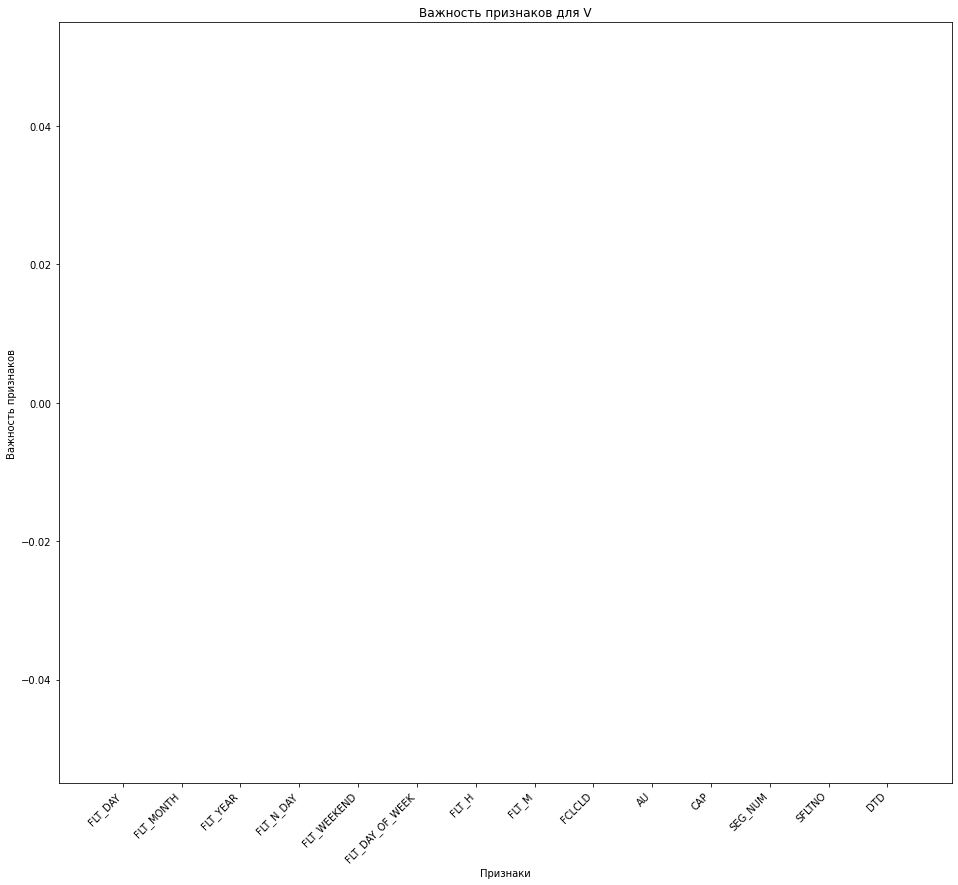

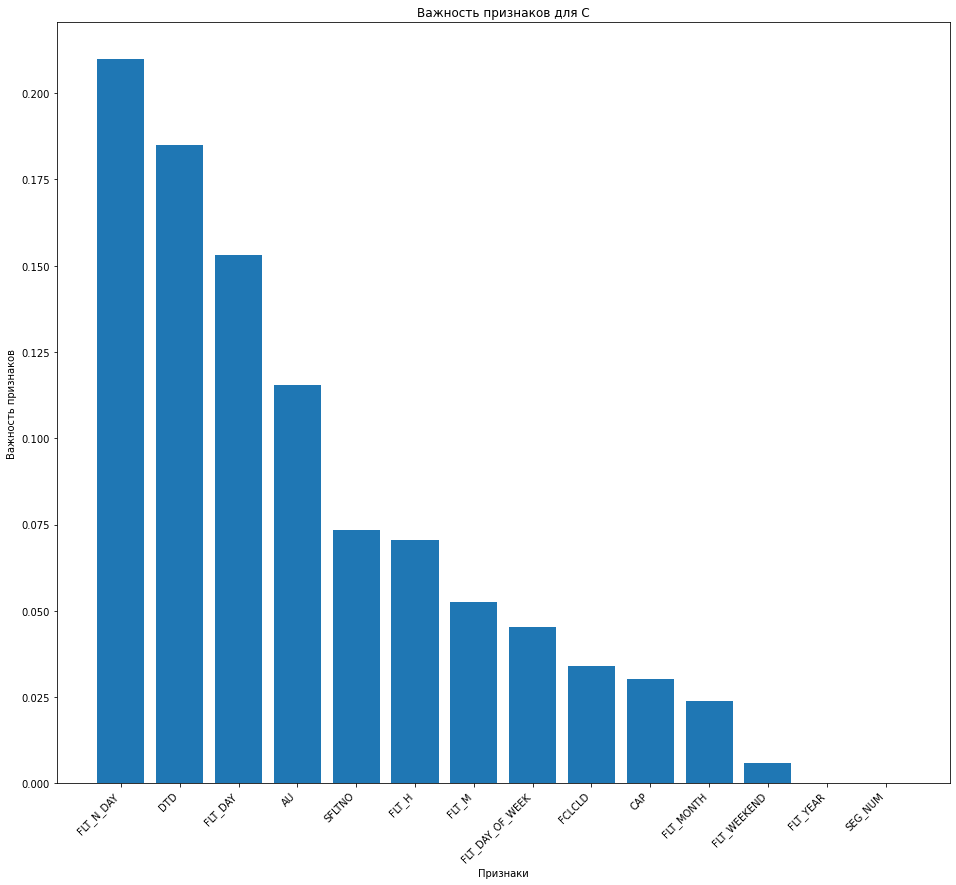

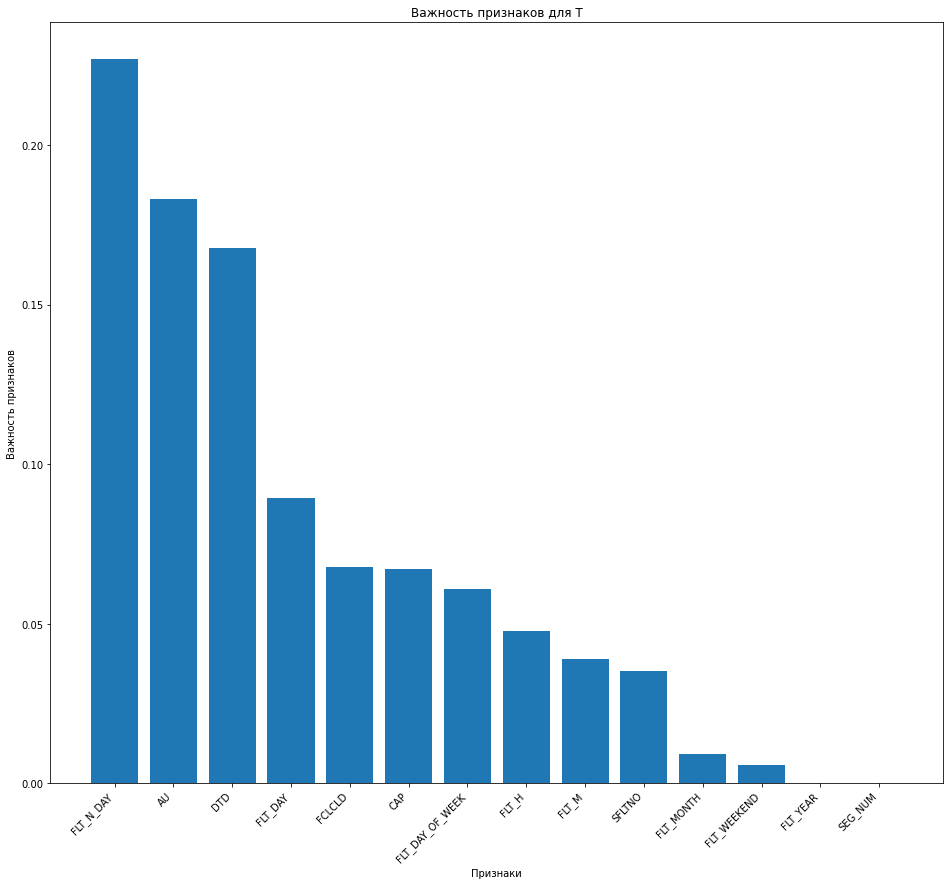

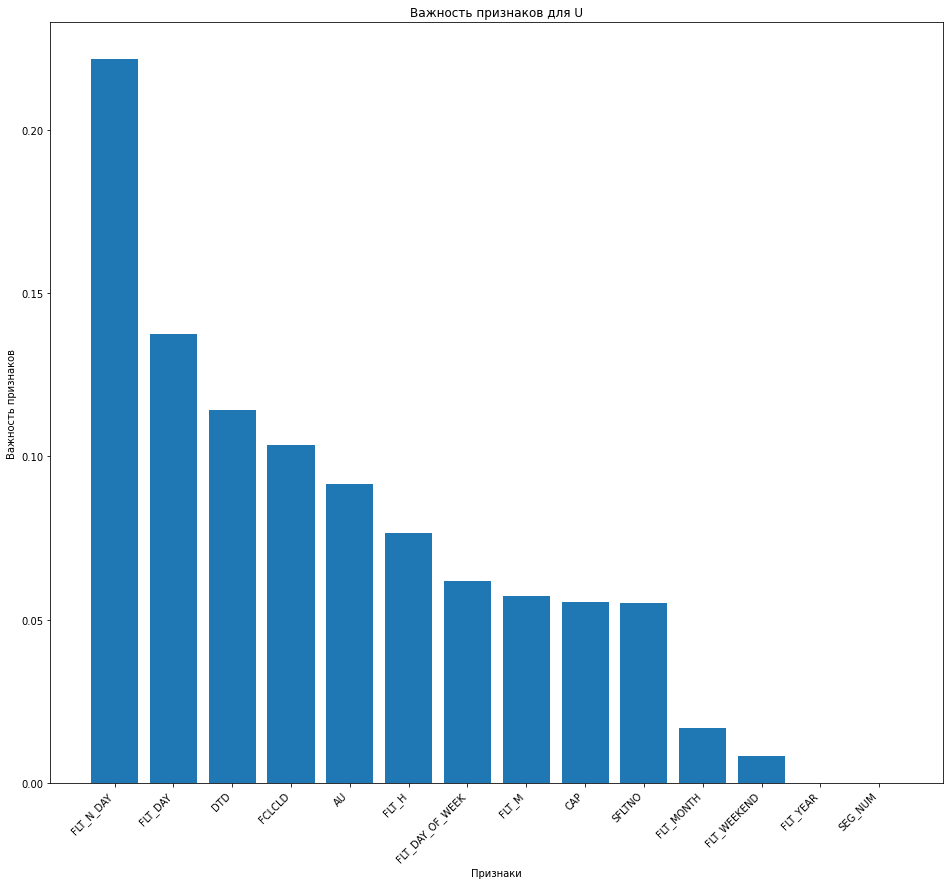

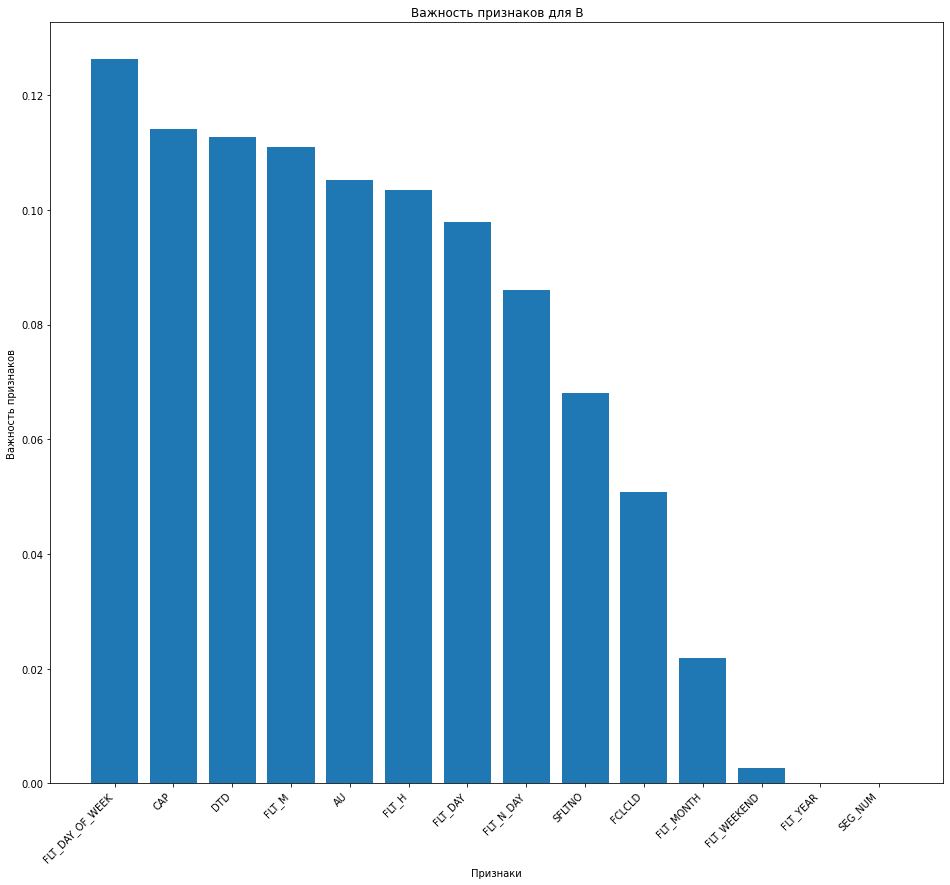

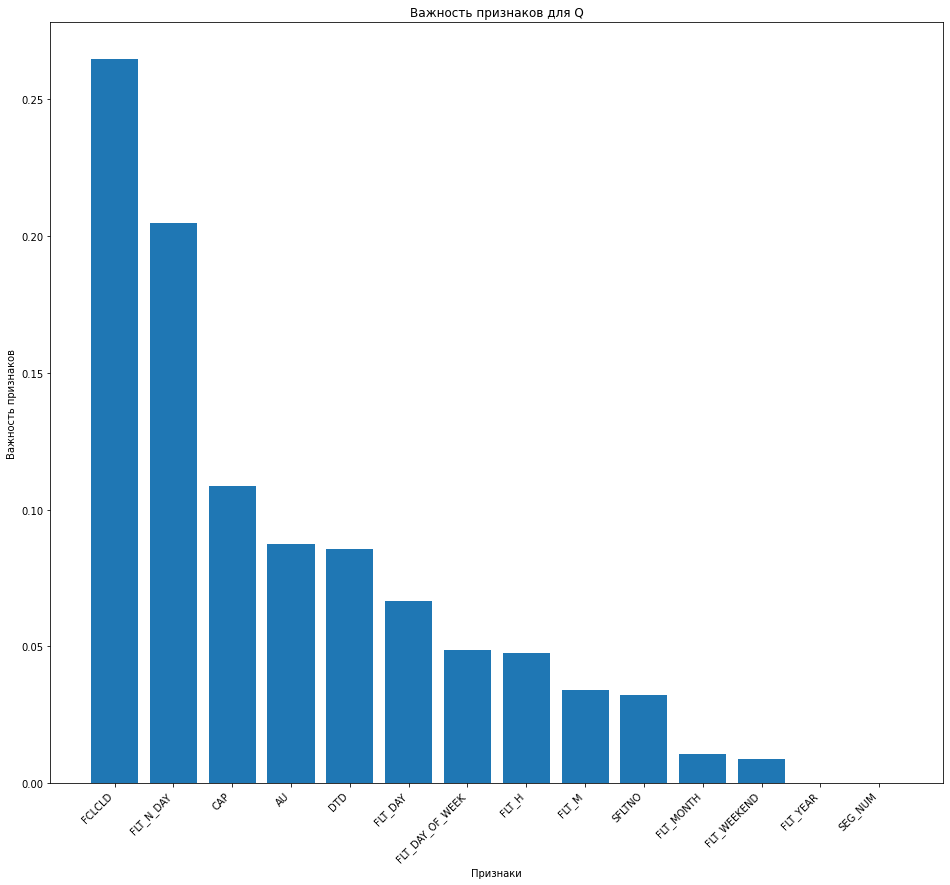

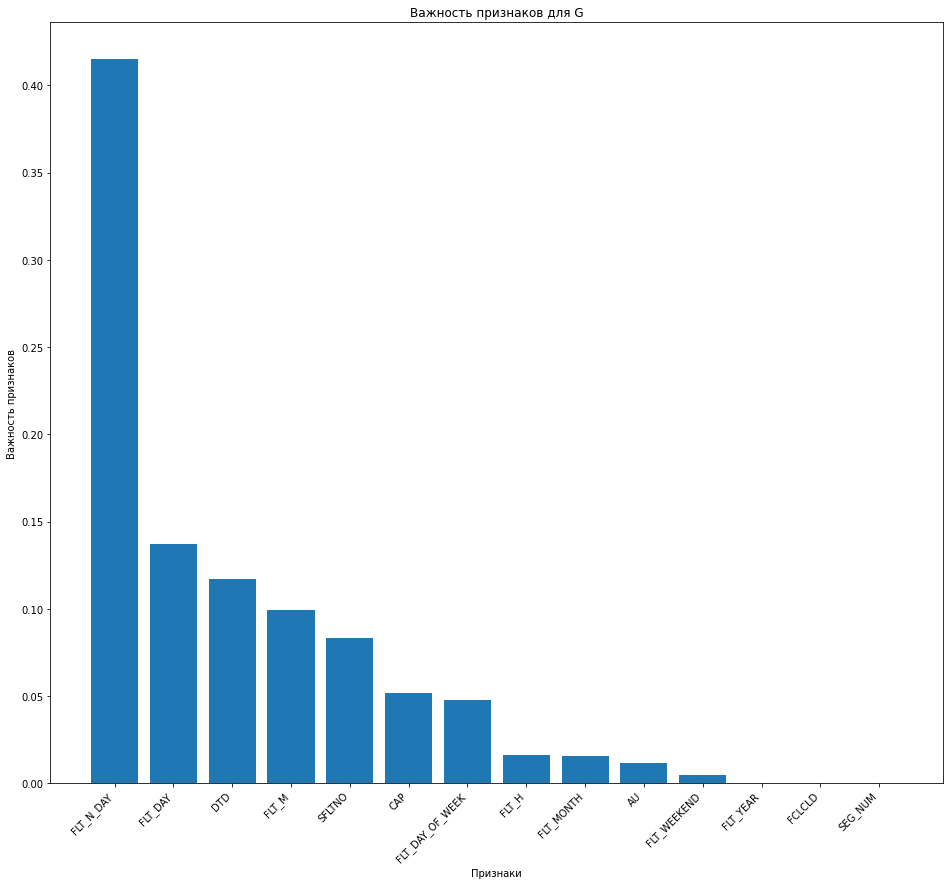

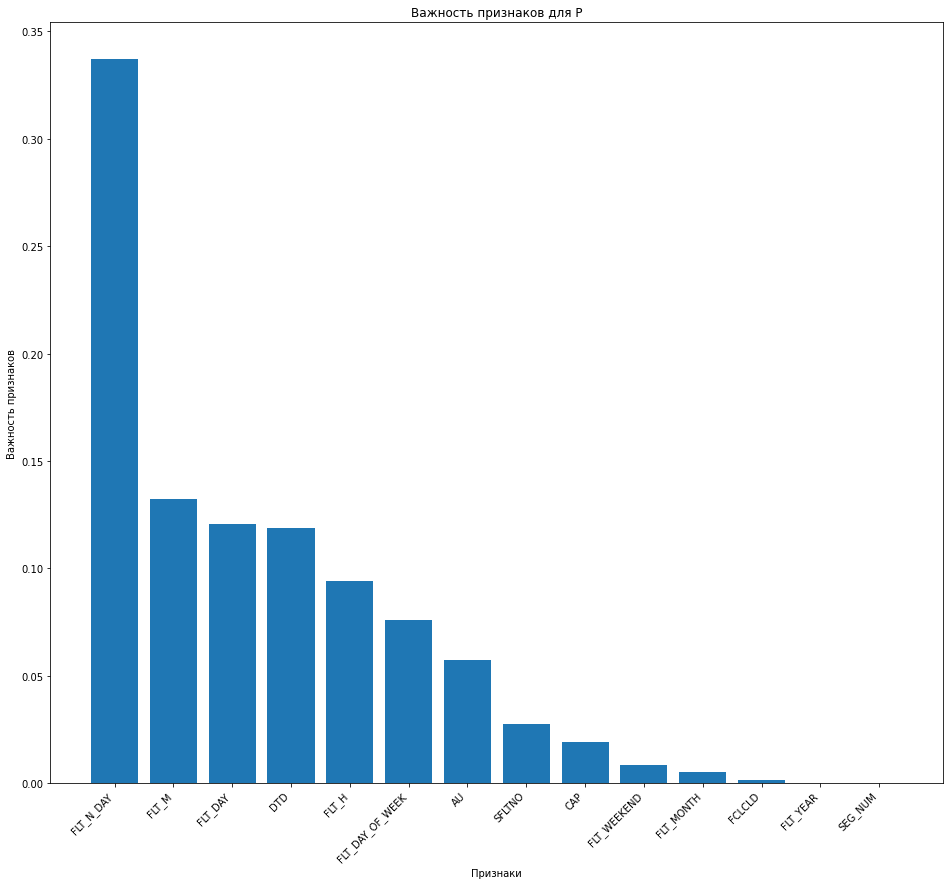

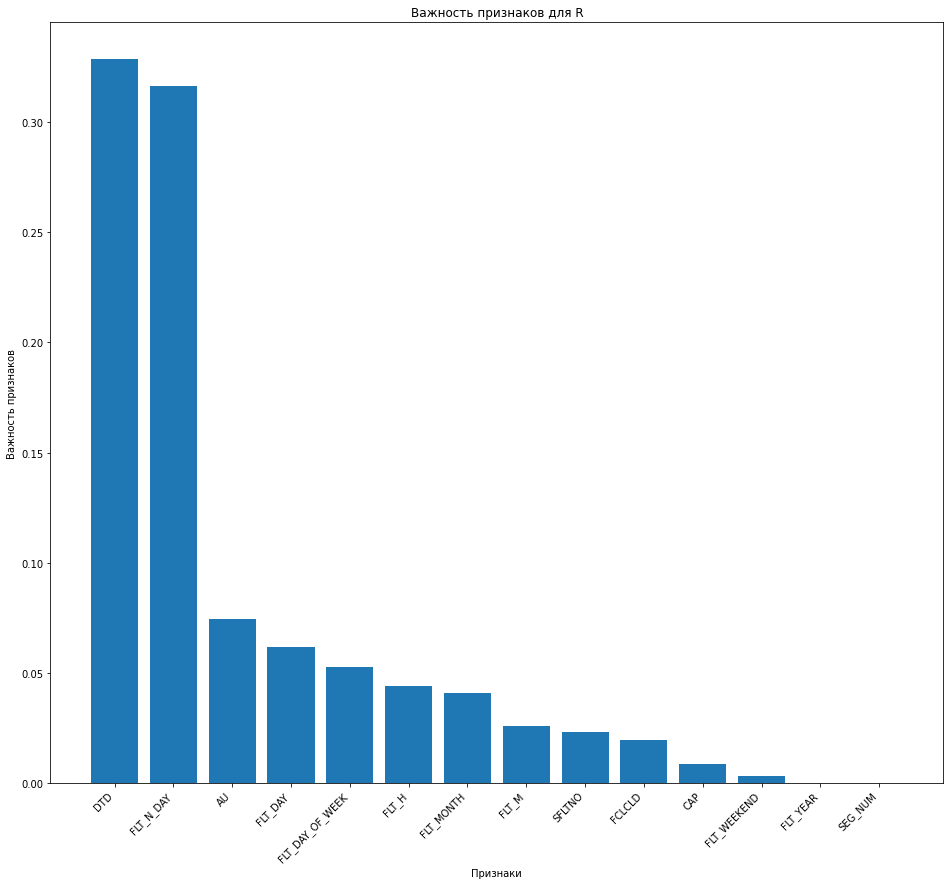

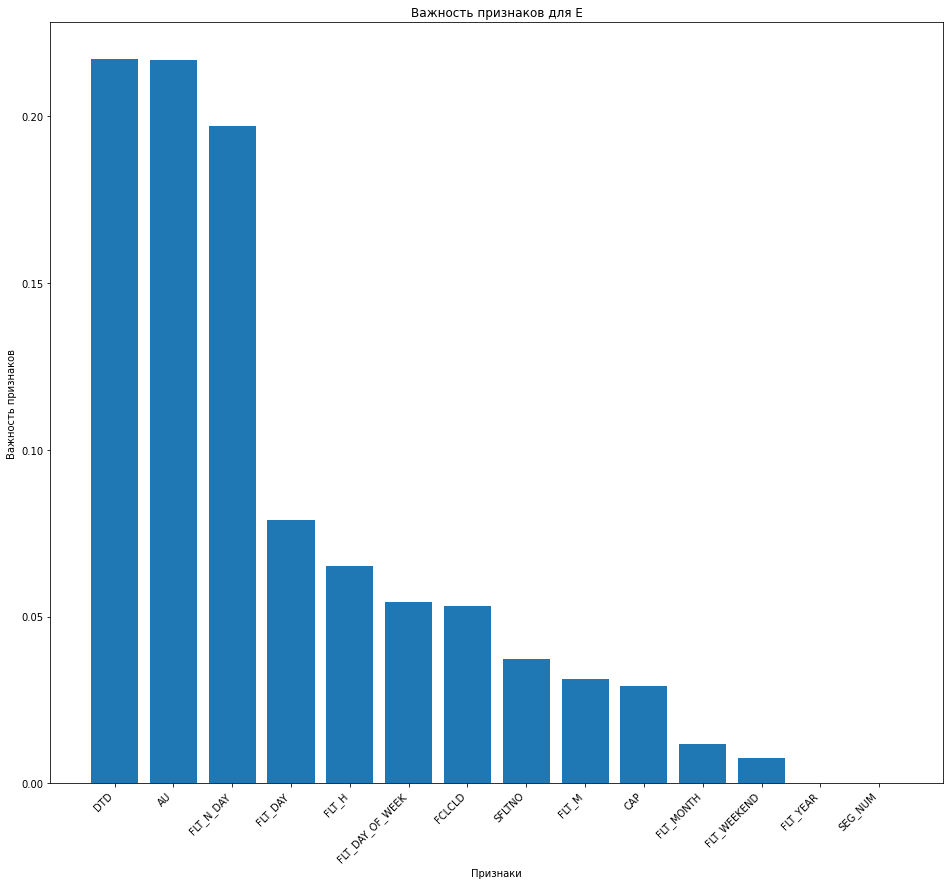

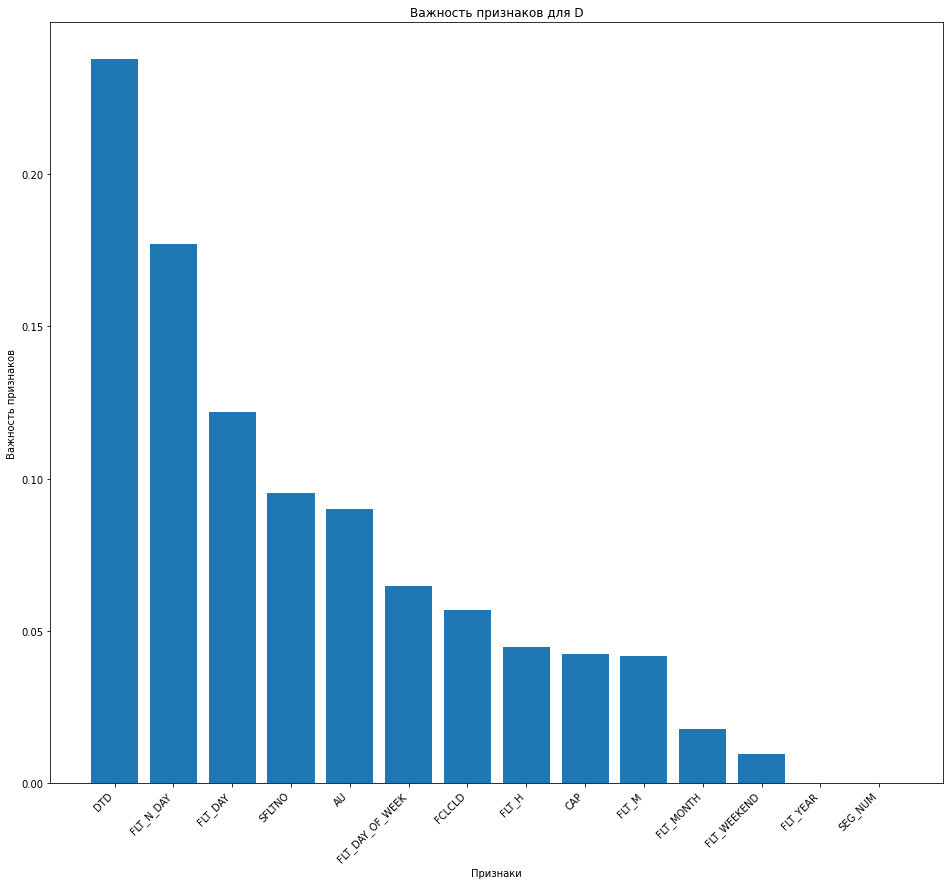

In [76]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, class_name):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title(f"Важность признаков для {class_name}")
    plt.show()

for class_name, model in models.items():# Вызов функции для вывода графика важности признаков
    plot_feature_importance(model, X.columns, class_name)

# Ансамблевые модели

In [80]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from mlxtend.regressor import StackingCVRegressor

In [81]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем модель Random Forest
        model_rf = RandomForestRegressor(n_estimators=10, random_state=42)
        model_rf.fit(X_train_scaled, y_train)
        
        # Строим и обучаем модель градиентного бустинга
        model_gb = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
        model_gb.fit(X_train_scaled, y_train)
        
        # Строим и обучаем модель AdaBoost
        model_ab = AdaBoostRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
        model_ab.fit(X_train_scaled, y_train)
        
        # Создаем модель стекинга
        models_stacking = [('rf', model_rf), ('gb', model_gb), ('ab', model_ab)]
        model = StackingCVRegressor(regressors=[model[1] for model in models_stacking], meta_regressor=LinearRegression(), cv=5)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.934314,0.007456
1,H,0.962159,0.543494
2,J,0.954864,0.064685
3,K,0.971380,0.169488
4,O,0.952182,0.046045
5,X,0.975865,0.151246
6,Y,0.925700,0.060559
7,N,0.978436,5.344255
8,L,0.983762,1.109228
9,Z,0.945784,0.004128


CPU times: user 3h 19min 34s, sys: 58.9 s, total: 3h 20min 33s
Wall time: 3h 19min 25s


In [82]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)

predictions_list = []

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
for class_name, prediction in all_predictions.items():
    predictions_list.append({'Класс': class_name, 'Предсказанное кол-во мест': math.ceil(float(prediction))})

# Создание DataFrame из списка предсказаний
predictions_df = pd.DataFrame(predictions_list)
predictions_df

кол-во дней: 10


,Класс,Предсказанное кол-во мест
0,I,1
1,H,2
2,J,23
3,K,0
4,O,1
5,X,0
6,Y,2
7,N,1
8,L,0
9,Z,1


In [83]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 10,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,6
6,Y,0
7,N,17
8,L,0
9,Z,2


In [85]:
merged_data = filtered_data_subset.merge(predictions_df, left_on='BCL', right_on='Класс', how='left')
merged_data.rename(columns={'PASS': 'Настоящее кол-во мест'}, inplace=True)
merged_data.drop(columns=['BCL'], inplace=True)
merged_data = merged_data[['Класс', 'Предсказанное кол-во мест', 'Настоящее кол-во мест']]
merged_data

,Класс,Предсказанное кол-во мест,Настоящее кол-во мест
0,I,1,0
1,H,2,0
2,J,23,2
3,K,0,0
4,O,1,0
5,X,0,6
6,Y,2,0
7,N,1,17
8,L,0,0
9,Z,1,2


In [86]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, class_name):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title(f"Важность признаков для {class_name}")
    plt.show()

for class_name, model in models.items():# Вызов функции для вывода графика важности признаков
    plot_feature_importance(model, X.columns, class_name)

Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.


# Ансамблевые модели 2

In [88]:
from xgboost import XGBRegressor

In [89]:
%%time
# Функция для чтения файла и подготовки данных
def read_and_process_file(filename):
    df = pd.read_csv(filename)
    X = df.drop(['BCL', 'PASS'], axis=1)  # Признаки: все столбцы кроме BCL и PASS
    y = df['PASS']  # Целевая переменная: количество открытых мест
    return X, y

# Путь к папке с файлами
folder_path = 'inv_2019_prep'

# Список для хранения моделей
models = {}

all_metrics_results = pd.DataFrame(columns=['Класс', 'R2 Score', 'MSE'])

# Проходим по всем файлам в папке
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        class_name = os.path.splitext(file)[0].split('_')[1]  # Получаем название класса из имени файла
        filename = os.path.join(folder_path, file)
        
        # Читаем и обрабатываем данные
        X, y = read_and_process_file(filename)
        
        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Нормализуем данные
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Строим и обучаем модель Random Forest
        model_rf = RandomForestRegressor(n_estimators=10, random_state=42)
        model_rf.fit(X_train_scaled, y_train)
        
        # Строим и обучаем модель градиентного бустинга
        model_gb = GradientBoostingRegressor(n_estimators=10, learning_rate=0.1, max_depth=3, random_state=42)
        model_gb.fit(X_train_scaled, y_train)
        
        model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=5, random_state=42)
        model_xgb.fit(X_train_scaled, y_train)
        
        # Создаем модель стекинга
        models_stacking = [('rf', model_rf), ('gb', model_gb), ('xgb', model_xgb)]
        model = StackingCVRegressor(regressors=[model[1] for model in models_stacking], meta_regressor=LinearRegression(), cv=5)
        model.fit(X_train_scaled, y_train)
        
        # Сохраняем модель
        models[class_name] = model
        
        # Оцениваем качество модели на тестовой выборке
        mse = mean_squared_error(y_test, model.predict(X_test_scaled))
        r2 = r2_score(y_test, model.predict(X_test_scaled))
        
         # Выводим результаты
        result = pd.DataFrame({
            'Класс': [class_name],
            'R2 Score': [r2],
            'MSE': [mse]
        })
        all_metrics_results = pd.concat([all_metrics_results, result], ignore_index=True)
display(all_metrics_results)

,Класс,R2 Score,MSE
0,I,0.934289,0.007459
1,H,0.962177,0.543234
2,J,0.954864,0.064685
3,K,0.971351,0.169659
4,O,0.952216,0.046012
5,X,0.975882,0.151142
6,Y,0.924543,0.061502
7,N,0.978458,5.338781
8,L,0.983768,1.108864
9,Z,0.945772,0.004129


CPU times: user 2h 35min 12s, sys: 16min 37s, total: 2h 51min 50s
Wall time: 1h 7min 19s


In [97]:
# Функция для предсказания количества открытых мест для всех классов по количеству дней до вылета
def predict_open_seats_for_all_classes(days_until_flight, features_dict):
    features = np.array([[features_dict[col] for col in X.columns]])
    predictions = {}
    for class_name, model in models.items():
        prediction = model.predict(features)
        predictions[class_name] = prediction[0]
    return predictions

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
days_until_flight = int(input('кол-во дней: ')) 
features_dict = {
    'DTD': days_until_flight,
    'SFLTNO': 1123,
    'SEG_NUM': 1,
    'CAP': 167,
    'AU': 129,
    'FCLCLD': 0,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY_OF_WEEK': 2,
    'FLT_WEEKEND': 0,
    'FLT_N_DAY': 30,
    'FLT_YEAR': 2019,
    'FLT_MONTH': 1,
    'FLT_DAY': 30
}  # Пример переданных признаков в виде словаря
all_predictions = predict_open_seats_for_all_classes(days_until_flight, features_dict)

predictions_list = []

# Пример использования функции для предсказания по количеству дней до вылета для всех классов
for class_name, prediction in all_predictions.items():
    predictions_list.append({'Класс': class_name, 'Предсказанное кол-во мест': math.ceil(float(prediction))})

# Создание DataFrame из списка предсказаний
predictions_df = pd.DataFrame(predictions_list)
predictions_df

кол-во дней: 100


,Класс,Предсказанное кол-во мест
0,I,0
1,H,2
2,J,23
3,K,0
4,O,1
5,X,0
6,Y,2
7,N,1
8,L,0
9,Z,1


In [98]:
def read_files_with_filter(folder_path, filter_conditions):
    # Создаем пустой DataFrame для хранения результатов
    filtered_data = pd.DataFrame()
    
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filename = os.path.join(folder_path, file)
            
            # Считываем файл и применяем фильтр
            df = pd.read_csv(filename)
            filtered_df = df[(df['DTD'] == filter_conditions['DTD']) &
                             (df['SFLTNO'] == filter_conditions['SFLTNO']) &
                             (df['FLT_M'] == filter_conditions['FLT_M']) &
                             (df['FLT_H'] == filter_conditions['FLT_H']) &
                             (df['FLT_DAY'] == filter_conditions['FLT_DAY']) &
                             (df['FLT_MONTH'] == filter_conditions['FLT_MONTH']) &
                             (df['FLT_YEAR'] == filter_conditions['FLT_YEAR'])]
            
            # Добавляем отфильтрованные данные в новый DataFrame
            filtered_data = pd.concat([filtered_data, filtered_df], ignore_index=True)
    
    return filtered_data

folder_path = 'inv_2019_prep'
filter_conditions = {
    'DTD': 100,
    'SFLTNO': 1123,
    'FLT_M': 45,
    'FLT_H': 12,
    'FLT_DAY': 30,
    'FLT_MONTH': 1,
    'FLT_YEAR': 2019
}

filtered_data = read_files_with_filter(folder_path, filter_conditions)
filtered_data_subset = filtered_data[['BCL', 'PASS']]
filtered_data_subset

,BCL,PASS
0,I,0
1,H,0
2,J,2
3,K,0
4,O,0
5,X,0
6,Y,0
7,N,2
8,L,0
9,Z,0


In [99]:
merged_data = filtered_data_subset.merge(predictions_df, left_on='BCL', right_on='Класс', how='left')
merged_data.rename(columns={'PASS': 'Настоящее кол-во мест'}, inplace=True)
merged_data.drop(columns=['BCL'], inplace=True)
merged_data = merged_data[['Класс', 'Предсказанное кол-во мест', 'Настоящее кол-во мест']]
merged_data

,Класс,Предсказанное кол-во мест,Настоящее кол-во мест
0,I,0,0
1,H,2,0
2,J,23,2
3,K,0,0
4,O,1,0
5,X,0,0
6,Y,2,0
7,N,1,2
8,L,0,0
9,Z,1,0


In [93]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, class_name):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title(f"Важность признаков для {class_name}")
    plt.show()

for class_name, model in models.items():# Вызов функции для вывода графика важности признаков
    plot_feature_importance(model, X.columns, class_name)

Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.
Модель не поддерживает оценку важности признаков.


In [45]:
%%time
def merge_invoice_data(start_date, end_date):
    merged_data = pd.DataFrame() 
 
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in date_range:
        file_name = f'data/INV{date.strftime("%d%m%Y")}.csv'  
        try:
            current_data = pd.read_csv(file_name, nrows=200000, sep=';')
            merged_data = pd.concat([merged_data, current_data], ignore_index=True)
        except FileNotFoundError:
            print(f'Файл {file_name} не найден.')
 
    return merged_data
 
start_date = '2019-12-01'
end_date = '2019-12-31'
inv = merge_invoice_data(start_date, end_date)

CPU times: user 24.2 s, sys: 7.46 s, total: 31.7 s
Wall time: 32 s


In [3]:
inv

,SDAT_S,DTD,SFLTNO,FLTDATE,DEP_TIME,SEG_NUM,ORIG,DEST,EQUIP,CAP,SCL,BCL,AU,PASS,NS,FCLCLD
0,21.03.2019,255,4,01.12.2019,640,1,SVO,LED,73H,138,Y,Y,152,0,0,0
1,21.03.2019,255,4,01.12.2019,640,1,SVO,LED,73H,20,C,J,20,2,0,0
2,21.03.2019,255,4,01.12.2019,640,1,SVO,LED,73H,138,Y,K,122,0,0,0
3,21.03.2019,255,4,01.12.2019,640,1,SVO,LED,73H,138,Y,R,0,0,0,1
4,21.03.2019,255,4,01.12.2019,640,1,SVO,LED,73H,138,Y,M,130,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199995,14.12.2019,17,37,31.12.2019,415,1,LED,SVO,32A,150,Y,N,30,42,0,1
6199996,14.12.2019,17,37,31.12.2019,415,1,LED,SVO,32A,150,Y,R,30,1,0,1
6199997,14.12.2019,17,37,31.12.2019,415,1,LED,SVO,32A,150,Y,Y,152,0,0,0
6199998,14.12.2019,17,37,31.12.2019,415,1,LED,SVO,32A,150,Y,M,144,0,0,0


In [4]:
inv = inv.sample(n=1_000_000, random_state=42)
inv

,SDAT_S,DTD,SFLTNO,FLTDATE,DEP_TIME,SEG_NUM,ORIG,DEST,EQUIP,CAP,SCL,BCL,AU,PASS,NS,FCLCLD
2870666,07.11.2019,38,17,15.12.2019,1325,1,LED,SVO,32A,150,Y,K,127,0,0,0
2940209,08.08.2019,129,29,15.12.2019,2150,1,LED,SVO,73H,138,Y,G,1,0,0,1
579514,29.07.2019,127,37,03.12.2019,415,1,LED,SVO,73H,138,Y,Q,73,0,0,0
1424358,11.05.2019,211,10,08.12.2019,815,1,SVO,LED,32B,167,Y,U,162,0,0,0
5939704,18.05.2019,226,28,30.12.2019,1930,1,SVO,LED,73H,138,Y,P,134,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118852,26.03.2019,250,27,01.12.2019,2110,1,LED,SVO,32B,167,Y,K,159,0,0,0
3362591,09.04.2019,252,33,17.12.2019,710,1,LED,SVO,32B,167,Y,B,165,0,0,0
1567637,03.11.2019,35,34,08.12.2019,2240,1,SVO,LED,32A,8,C,Z,4,0,0,0
539432,20.07.2019,136,30,03.12.2019,2020,1,SVO,LED,320,20,C,J,20,2,0,0


In [48]:
bb = pd.read_csv('data/dec2019.csv', nrows=717609, sep=';', encoding='windows-1251')
bb

,Дата бронирования,Время бронирования,Дата вылета рейса,Время вылета рейса,Компания,Номер рейса,Класс бронирования,Кабина,Порт вылета,Порт прилета,Кол-во мест,Статус,Признак групп. бронирования,Данные пункта продажи,CREATE_IATA_NUM,Дата рождения,Пол,Номер локатора SU
0,05.12.2019,05.12.2019 13:43:00,27.03.2020,27.03.2020 11:05:00,SU,291.0,R,Y,HAN,SVO,1,WK,N,DSU,NaN,20.07.1965,M,BLGRLP
1,08.12.2019,08.12.2019 11:08:00,02.05.2020,02.05.2020 22:15:00,SU,1532.0,L,Y,SVO,CEK,3,UC,N,DSU,NaN,29.03.1984,F,QDSDBJ
2,08.12.2019,08.12.2019 11:08:00,07.04.2020,07.04.2020 22:15:00,SU,1532.0,L,Y,SVO,CEK,3,SS,N,DSU,NaN,25.05.1974,M,QDSDBJ
3,08.12.2019,08.12.2019 11:09:00,24.02.2020,24.02.2020 12:05:00,SU,2169.0,E,Y,BRU,SVO,2,SC,N,DSU,NaN,18.06.1978,F,MCHBOF
4,19.12.2019,19.12.2019 5:07:00,01.05.2020,01.05.2020 23:20:00,SU,2595.0,E,Y,MUC,SVO,2,HK,N,TTY,9222953.0,18.09.1953,F,KZVDYF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717604,25.12.2019,25.12.2019 4:36:00,22.11.2020,22.11.2020 9:50:00,SU,1443.0,N,Y,IKT,SVO,1,SS,N,JQZ,NaN,01.05.1954,F,KIBHHX
717605,24.12.2019,24.12.2019 6:54:00,25.12.2020,25.12.2020 10:00:00,SU,2996.0,Y,Y,AAA,AAB,2,SS,N,DSU,NaN,16.05.1958,F,SIFKYT
717606,24.12.2019,24.12.2019 3:02:00,18.01.2020,18.01.2020 17:25:00,SU,1106.0,N,Y,SVO,KRR,3,HK,N,DSU,NaN,21.12.2001,F,HUFXTL
717607,27.12.2019,27.12.2019 8:54:00,16.01.2020,16.01.2020 8:25:00,SU,2482.0,N,Y,SVO,VRN,8,HK,N,DSU,NaN,11.08.1976,M,XHFWJW


In [49]:
bb = bb[(bb['Порт вылета'] == 'SVO') & (bb['Порт прилета'] == 'LED')]
bb.shape

(16645, 18)

In [46]:
inv['ORIG'].unique()

array(['SVO', 'LED'], dtype=object)

In [47]:
inv['DEST'].unique()

array(['LED', 'SVO'], dtype=object)

In [50]:
inv = inv[(inv['ORIG'] == 'SVO') & (inv['DEST'] == 'LED')]
inv.shape

(3144602, 16)

In [51]:
merged = pd.merge(bb, inv, left_on=['Номер рейса', 'Дата вылета рейса', 'Порт вылета','Порт прилета'],
                                         right_on=['SFLTNO', 'FLTDATE','ORIG','DEST'])
merged.shape

/Users/manforten/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1140: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


(34159436, 34)

In [53]:
merged.dtypes

Дата бронирования               object
Время бронирования              object
Дата вылета рейса               object
Время вылета рейса              object
Компания                        object
Номер рейса                    float64
Класс бронирования              object
Кабина                          object
Порт вылета                     object
Порт прилета                    object
Кол-во мест                      int64
Статус                          object
Признак групп. бронирования     object
Данные пункта продажи           object
CREATE_IATA_NUM                float64
Дата рождения                   object
Пол                             object
Номер локатора SU               object
SDAT_S                          object
DTD                              int64
SFLTNO                           int64
FLTDATE                         object
DEP_TIME                         int64
SEG_NUM                          int64
ORIG                            object
DEST                     

In [10]:
merged['BCL']

0          M
1          U
2          B
3          Y
4          X
          ..
4485302    Y
4485303    O
4485304    Q
4485305    M
4485306    K
Name: BCL, Length: 4485307, dtype: object

In [54]:
data = merged[['Дата вылета рейса', 'Время вылета рейса', 'Класс бронирования', 'Кабина', 'Порт вылета', 'Порт прилета', 'Кол-во мест', 'Статус', 'Признак групп. бронирования', 'DTD', 'SFLTNO', 'SEG_NUM', 'CAP', 'SCL', 'BCL', 'AU', 'PASS', 'NS', 'FCLCLD']]

In [55]:
data.dtypes

Дата вылета рейса              object
Время вылета рейса             object
Класс бронирования             object
Кабина                         object
Порт вылета                    object
Порт прилета                   object
Кол-во мест                     int64
Статус                         object
Признак групп. бронирования    object
DTD                             int64
SFLTNO                          int64
SEG_NUM                         int64
CAP                             int64
SCL                            object
BCL                            object
AU                              int64
PASS                            int64
NS                              int64
FCLCLD                          int64
dtype: object

In [56]:
data

,Дата вылета рейса,Время вылета рейса,Класс бронирования,Кабина,Порт вылета,Порт прилета,Кол-во мест,Статус,Признак групп. бронирования,DTD,SFLTNO,SEG_NUM,CAP,SCL,BCL,AU,PASS,NS,FCLCLD
0,28.12.2019,28.12.2019 10:10:00,R,Y,SVO,LED,1,HK,N,282,14,1,167,Y,E,100,0,0,0
1,28.12.2019,28.12.2019 10:10:00,R,Y,SVO,LED,1,HK,N,282,14,1,167,Y,X,134,0,0,0
2,28.12.2019,28.12.2019 10:10:00,R,Y,SVO,LED,1,HK,N,282,14,1,167,Y,L,142,0,0,0
3,28.12.2019,28.12.2019 10:10:00,R,Y,SVO,LED,1,HK,N,282,14,1,16,C,Z,6,0,0,0
4,28.12.2019,28.12.2019 10:10:00,R,Y,SVO,LED,1,HK,N,282,14,1,16,C,C,14,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34159431,10.12.2019,10.12.2019 1:50:00,N,Y,SVO,LED,1,HK,N,-1,36,1,138,Y,B,140,0,0,1
34159432,10.12.2019,10.12.2019 1:50:00,N,Y,SVO,LED,1,HK,N,-1,36,1,138,Y,N,101,15,0,1
34159433,10.12.2019,10.12.2019 1:50:00,N,Y,SVO,LED,1,HK,N,-1,36,1,138,Y,G,19,0,0,1
34159434,10.12.2019,10.12.2019 1:50:00,N,Y,SVO,LED,1,HK,N,-1,36,1,138,Y,Y,141,0,1,1


In [26]:
data['BCL'].unique()

array(['M', 'U', 'B', 'Y', 'X', 'T', 'N', 'G', 'I', 'Q', 'C', 'Z', 'O',
       'L', 'V', 'H', 'J', 'D', 'E', 'K', 'R', 'P'], dtype=object)

In [21]:
data

,Дата вылета рейса,Время вылета рейса,Класс бронирования,Кабина,Порт вылета,Порт прилета,Кол-во мест,Статус,Признак групп. бронирования,DTD,SFLTNO,SEG_NUM,CAP,SCL,BCL,AU,PASS,NS,FCLCLD
0,23.12.2019,23.12.2019 10:10:00,N,Y,SVO,LED,1,HK,N,249,14,1,167,Y,M,164,0,0,0
1,23.12.2019,23.12.2019 10:10:00,N,Y,SVO,LED,1,HK,N,168,14,1,167,Y,U,140,0,0,0
2,23.12.2019,23.12.2019 10:10:00,N,Y,SVO,LED,1,HK,N,147,14,1,167,Y,B,163,0,0,0
3,23.12.2019,23.12.2019 10:10:00,N,Y,SVO,LED,1,HK,N,206,14,1,167,Y,Y,170,0,0,0
4,23.12.2019,23.12.2019 10:10:00,N,Y,SVO,LED,1,HK,N,116,14,1,167,Y,X,101,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485302,10.12.2019,10.12.2019 4:15:00,R,Y,LED,SVO,1,HK,N,157,37,1,138,Y,Y,141,0,0,0
4485303,10.12.2019,10.12.2019 4:15:00,R,Y,LED,SVO,1,HK,N,232,37,1,20,C,O,8,0,0,0
4485304,10.12.2019,10.12.2019 4:15:00,R,Y,LED,SVO,1,HK,N,108,37,1,138,Y,Q,76,0,0,0
4485305,10.12.2019,10.12.2019 4:15:00,R,Y,LED,SVO,1,HK,N,200,37,1,138,Y,M,135,0,0,0


In [27]:
data['Класс бронирования'].unique()

array(['N ', 'O ', 'D ', 'E ', 'R ', 'J ', 'T ', 'Q ', 'G ', 'C ', 'H ',
       'L ', 'Y ', 'M ', 'U ', 'B ', 'K ', 'X ', 'Z ', 'P ', 'I ', 'V ',
       'S ', 'W '], dtype=object)

In [21]:
data[(data['Дата вылета рейса']=='28.12.2019')|(data['Номер рейса']==14)].sort_values(by='PASS')

,Дата вылета рейса,Время вылета рейса,Номер рейса,Класс бронирования,Кабина,Порт вылета,Порт прилета,Кол-во мест,Статус,Признак групп. бронирования,...,SFLTNO,FLTDATE,SEG_NUM,CAP,SCL,BCL,AU,PASS,NS,FCLCLD
0,23.12.2019,23.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,23.12.2019,1,167,Y,M,164,0,0,0
3639952,08.12.2019,08.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,08.12.2019,1,16,C,Z,6,0,0,0
3639954,08.12.2019,08.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,08.12.2019,1,8,C,C,7,0,0,0
3639955,08.12.2019,08.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,08.12.2019,1,167,Y,N,67,0,0,0
3639956,08.12.2019,08.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,08.12.2019,1,16,C,D,10,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512380,18.12.2019,18.12.2019 10:10:00,14.0,C,C,SVO,LED,1,HK,N,...,14,18.12.2019,1,150,Y,N,146,105,0,1
3511440,18.12.2019,18.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,18.12.2019,1,150,Y,N,146,105,0,1
3510500,18.12.2019,18.12.2019 10:10:00,14.0,N,Y,SVO,LED,1,HK,N,...,14,18.12.2019,1,150,Y,N,146,105,0,1
3508620,18.12.2019,18.12.2019 10:10:00,14.0,N,Y,SVO,LED,2,SS,N,...,14,18.12.2019,1,150,Y,N,146,105,0,1


In [22]:
data = pd.get_dummies(data, columns=['Класс бронирования', 'Кабина', 'Порт вылета', 'Порт прилета', 'Статус', 'Признак групп. бронирования','SCL','BCL'])

In [23]:
data

,Дата вылета рейса,Время вылета рейса,Номер рейса,Кол-во мест,DTD,SFLTNO,FLTDATE,SEG_NUM,CAP,AU,...,BCL_O,BCL_P,BCL_Q,BCL_R,BCL_T,BCL_U,BCL_V,BCL_X,BCL_Y,BCL_Z
0,23.12.2019,23.12.2019 10:10:00,14.0,1,249,14,23.12.2019,1,167,164,...,0,0,0,0,0,0,0,0,0,0
1,23.12.2019,23.12.2019 10:10:00,14.0,1,168,14,23.12.2019,1,167,140,...,0,0,0,0,0,1,0,0,0,0
2,23.12.2019,23.12.2019 10:10:00,14.0,1,147,14,23.12.2019,1,167,163,...,0,0,0,0,0,0,0,0,0,0
3,23.12.2019,23.12.2019 10:10:00,14.0,1,206,14,23.12.2019,1,167,170,...,0,0,0,0,0,0,0,0,1,0
4,23.12.2019,23.12.2019 10:10:00,14.0,1,116,14,23.12.2019,1,167,101,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485302,10.12.2019,10.12.2019 4:15:00,37.0,1,157,37,10.12.2019,1,138,141,...,0,0,0,0,0,0,0,0,1,0
4485303,10.12.2019,10.12.2019 4:15:00,37.0,1,232,37,10.12.2019,1,20,8,...,1,0,0,0,0,0,0,0,0,0
4485304,10.12.2019,10.12.2019 4:15:00,37.0,1,108,37,10.12.2019,1,138,76,...,0,0,1,0,0,0,0,0,0,0
4485305,10.12.2019,10.12.2019 4:15:00,37.0,1,200,37,10.12.2019,1,138,135,...,0,0,0,0,0,0,0,0,0,0


In [24]:
data.dtypes

Дата вылета рейса      object
Время вылета рейса     object
Номер рейса           float64
Кол-во мест             int64
DTD                     int64
                       ...   
BCL_U                   uint8
BCL_V                   uint8
BCL_X                   uint8
BCL_Y                   uint8
BCL_Z                   uint8
Length: 161, dtype: object

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


# Преобразование категориальных признаков в числовые с помощью LabelEncoder
label_encoders = {}
categorical_cols = ['Класс бронирования', 'Кабина', 'Порт вылета', 'Порт прилета', 'Признак групп. бронирования', 'SCL', 'BCL']
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Разделение данных на обучающую и тестовую выборки
X = data.drop(columns=['Кол-во мест'])
y = data['Кол-во мест']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в тензоры PyTorch
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_tensor = torch.tensor(X_train[numeric_cols].values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test[numeric_cols].values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Определение архитектуры нейронной сети
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Инициализация модели
input_size = len(numeric_cols)
net = Net(input_size)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Обучение модели на видеокарте
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Предсказание на тестовой выборке
X_test_tensor = X_test_tensor.to(device)
outputs = net(X_test_tensor)
predictions = outputs.cpu().detach().numpy().flatten()

# Вычисление MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Функция для предсказания количества мест для заданного класса бронирования и даты вылета
def predict_seats(net, input_data):
    input_data = input_data.copy()
    for col, le in label_encoders.items():
        input_data[col] = le.transform([input_data[col]])[0]
    input_tensor = torch.tensor(input_data[numeric_cols].values, dtype=torch.float32).view(1, -1).to(device)
    output = net(input_tensor)
    return output.item()

# Пример использования функции для предсказания количества мест
input_data = {
    'Дата вылета рейса': '2024-04-01',
    'Время вылета рейса': '12:00:00',
    'Класс бронирования': 'B',
    'Кабина': 'Y',
    'Порт вылета': 'ROV',
    'Порт прилета': 'SVO',
    'Признак групп. бронирования': 'N',
    'DTD': 10,
    'SFLTNO': 1234,
    'FLTDATE': '2024-04-01',
    'SEG_NUM': 1,
    'CAP': 150,
    'SCL': 'Y',
    'BCL': 'B',
    'AU': 50,
    'PASS': 100,
    'NS': 0,
    'FCLCLD': 0
}

predicted_seats = predict_seats(net, pd.DataFrame([input_data]))
print(f'Для класса B: {predicted_seats}')


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import math

In [31]:
data['Время вылета рейса'] = pd.to_datetime(data['Время вылета рейса']).astype(int) / 10**9 
data['FLTDATE'] = pd.to_datetime(data['FLTDATE']).astype(int) / 10**9 
data['Дата вылета рейса'] = pd.to_datetime(data['Дата вылета рейса']).astype(int) / 10**9 

In [38]:
from sklearn.ensemble import RandomForestRegressor
classes = ['M', 'U', 'B', 'Y', 'X', 'T', 'N', 'G', 'I', 'Q', 'C', 'Z', 'O',
       'L', 'V', 'H', 'J', 'D', 'E', 'K', 'R', 'P']
# Обучение модели для каждого класса
predictions_by_class = {}

for class_name in classes:
    # Формирование данных для текущего класса
    class_data = data[data['BCL_' + class_name] == 1]
    
    X = class_data.drop(columns=['Кол-во мест'])
    y = class_data['Кол-во мест']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=10, random_state=42) 
    model.fit(X_train, y_train)
    
    # Оценка производительности модели на тестовом наборе
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error для класса {class_name}: {mae}')

    # Предсказание для новой даты
    new_data = X.iloc[0:1, :]
    new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()
    predicted_pass_bk = model.predict(new_data)[0]
    
    predictions_by_class[class_name] = predicted_pass_bk

# Вывод предсказаний для каждого класса
for class_name, prediction in predictions_by_class.items():
    print(f'Предсказанное количество открытых мест для класса {class_name}: {math.ceil(prediction)}')

Mean Absolute Error для класса M: 0.25380543389573823


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса U: 0.2574612034833714


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса B: 0.26475851271585743


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса Y: 0.2532425416971996


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса X: 0.257521242243769


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса T: 0.2580040366242735


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса N: 0.26090053319011614


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса G: 0.25575239196411725


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса I: 0.25715011461764437


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса Q: 0.2514156146485924


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса C: 0.2608737800434715


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса Z: 0.25775397083404894


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса O: 0.2618842269682331


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса L: 0.2619516983247289


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса V: 0.26213810643281743


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса H: 0.2554783780580796


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса J: 0.26281523222084135


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса D: 0.2603514792578925


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса E: 0.26034357667582414


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса K: 0.2595071310348474


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса R: 0.25350111179584256


<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


Mean Absolute Error для класса P: 0.2603766552999335
Предсказанное количество открытых мест для класса M: 2
Предсказанное количество открытых мест для класса U: 2
Предсказанное количество открытых мест для класса B: 2
Предсказанное количество открытых мест для класса Y: 2
Предсказанное количество открытых мест для класса X: 2
Предсказанное количество открытых мест для класса T: 2
Предсказанное количество открытых мест для класса N: 2
Предсказанное количество открытых мест для класса G: 2
Предсказанное количество открытых мест для класса I: 2
Предсказанное количество открытых мест для класса Q: 2
Предсказанное количество открытых мест для класса C: 2
Предсказанное количество открытых мест для класса Z: 2
Предсказанное количество открытых мест для класса O: 2
Предсказанное количество открытых мест для класса L: 2
Предсказанное количество открытых мест для класса V: 2
Предсказанное количество открытых мест для класса H: 2
Предсказанное количество открытых мест для класса J: 2
Предсказанно

<ipython-input-38-b715d4b4be4c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Дата вылета рейса'] = pd.to_datetime('2019-12-23').timestamp()


In [ ]:
target_date = pd.to_datetime('2018-01-02')
target_classes = ['J', 'C', 'D', 'I', 'Z', 'O', 'Y', 'B', 'M', 'U', 'P', 'K', 'H', 'L', 'X', 'Q', 'T', 'E',
 'N', 'R', 'G', 'V']
filtered_data = hh[(hh['DD'] == target_date) & (hh['SEG_CLASS_CODE'].isin(target_classes))]

for class_name in target_classes:
    class_data = filtered_data[filtered_data['SEG_CLASS_CODE'] == class_name]
    if not class_data.empty:
        real_value = class_data.iloc[0]['PASS_BK']
        print(f"Реальное количество забронированных мест для класса {class_name}: {real_value}")

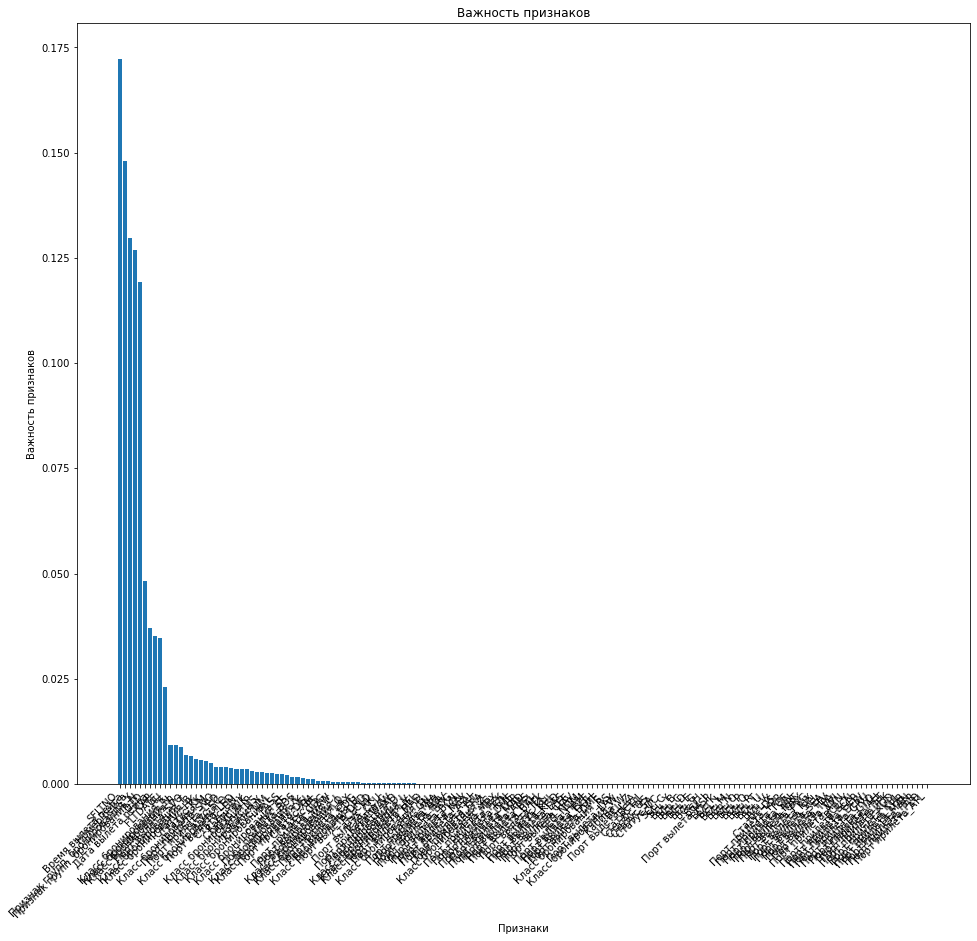

In [47]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names):
    if not hasattr(model, 'feature_importances_'):
        print("Модель не поддерживает оценку важности признаков.")
        return

    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]

    plt.figure(figsize=(16, 14))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), [feature_names[i] for i in sorted_idx], rotation=45, ha="right")
    plt.xlabel("Признаки")
    plt.ylabel("Важность признаков")
    plt.title("Важность признаков")
    plt.show()

# Вызов функции для вывода графика важности признаков
plot_feature_importance(model, X.columns)

